In [1]:
workingDir=r"E:\biofilmCommunities" #change this to path of working directory
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import skimage.io
from scipy.io import loadmat
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import Rbf, RBFInterpolator, RegularGridInterpolator
from scipy.stats import ttest_1samp,ttest_ind,tukey_hsd,f_oneway
from scipy.signal import find_peaks,savgol_filter
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib
import os
from glob import glob
from statannotations.Annotator import Annotator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
matplotlib.rcParams.update({'font.size': 18}) #change font size
savePath=os.path.join(workingDir,'outputs')
dataPath=os.path.join(workingDir,'data')

In [2]:
def readTiff(tiffFile,numFrames=18,imSize=256): #read time course tiff files
    img=skimage.io.imread(tiffFile)
    return np.reshape(img,[numFrames,int(img.shape[0]/numFrames),imSize,imSize,3]) 

def imagesc(img,quantileLims=(0.05,0.95),lims=None,ax=None,**kwargs): #show images
    if lims is None:
        vmin=np.quantile(img,quantileLims[0],axis=(0,1))
        vmax=np.quantile(img,quantileLims[1],axis=(0,1))
    else:
        vmin=lims[0]
        vmax=lims[1]
    if ax is None:
        return plt.imshow((img-vmin)/(vmax-vmin),**kwargs)
    else:
        return ax.imshow((img-vmin)/(vmax-vmin),**kwargs)

def logisticFunc(x,a,b,c,x0): #define logistic function for fitting
    return a/(1+np.exp((x-x0)/b))+c

def fitX0(y,x=None,bounds=None): #fit logistic function to data
    if x is None:
        x=range(len(y))
    if bounds is None:
        bounds=([0,0,0,min(x)],[np.max(y),max(x)-min(x),np.max(y),max(x)])
    params,_=curve_fit(f=logisticFunc,
          xdata=x,ydata=y,
          method='trf',bounds=bounds)
    return params

def fitSlice(imgZsum,lim1,lim2,frame,channel,xlims=None,umPerPixel=850/256): #use logistic function to fit image region, summing across one dimension to generate slice
    if channel==1:
        imgSlice=imgZsum[frame,lim1:lim2,:,channel]
    elif channel==0:
        imgSlice=imgZsum[frame,:,lim1:lim2,channel].T
    else:
        return None
    if xlims is None:
        xlims=[0,imgSlice.shape[1]]
    xlims[0]=np.max([0,xlims[0]])
    xlims[1]=np.min([imgSlice.shape[1],xlims[1]])
    y=np.sum(imgSlice[:,xlims[0]:xlims[1]],axis=0)
    x=umPerPixel*np.arange(*xlims)
    x=x[y>0]
    y=y[y>0]
    ymin=np.min(y)
    ymax=np.max(y)
    params=fitX0(x=x,y=y)
    return params

def getLinePlotDf(imgSlice,time,xlims=None,umPerPixel=850/256): #generate dataframe with underlying data and logistic function fit values
    if xlims is None:
        xlims=[0,imgSlice.shape[1]]
    y=np.sum(imgSlice[:,xlims[0]:xlims[1]],axis=0)
    x=umPerPixel*np.arange(*xlims)
    x=x[y>0]
    y=y[y>0]
    ymin=np.min(y)
    ymax=np.max(y)
    params=fitX0(x=x,y=y)
    yFit=logisticFunc(x=x,a=params[0],b=params[1],c=params[2],x0=params[-1])
    df1=pd.DataFrame({'x':x,'y':(y-ymin)/(ymax-ymin)})
    df1['type']='data'
    df2=pd.DataFrame({'x':x,'y':(yFit-ymin)/(ymax-ymin)})
    df2['type']='fit'
    df=pd.concat([df1,df2])
    df['time']=time
    return params,df

def getMeanFluorescence(img,rep,xlims=None,ylims=None,boxSize=50): #calculate mean fluorescence in confocal data of successively patterned biofilms (SS-GFP in stripe on left, IC-RFP in stripe along top)
    imgSize=img.shape[-2]
    if len(img.shape)==5:
        frame0=np.squeeze(img[0,:,:,:,:])
    else:
        frame0=img
    if xlims is None and ylims is None:
        redBoundary=fitX0(np.sum(frame0[:,:,:,0],axis=(0,2)))[-1]
        greenBoundary=fitX0(np.sum(frame0[:,:,:,1],axis=(0,1)))[-1]
        xlims=np.round([(greenBoundary-boxSize)/2,
                        (greenBoundary+boxSize)/2,
                        (greenBoundary+imgSize-boxSize)/2,
                        (greenBoundary+imgSize+boxSize)/2]).astype(int)
        ylims=np.round([(redBoundary-boxSize)/2,
                        (redBoundary+boxSize)/2,
                        (redBoundary+imgSize-boxSize)/2,
                        (redBoundary+imgSize+boxSize)/2]).astype(int)
    elif ylims is None:
        ylims=xlims
    df=pd.DataFrame([np.mean(frame0[:,ylims[0]:ylims[1],xlims[0]:xlims[1],:],axis=(0,1,2)),
                     np.mean(frame0[:,ylims[0]:ylims[1],xlims[2]:xlims[3],:],axis=(0,1,2)),
                     np.mean(frame0[:,ylims[2]:ylims[3],xlims[0]:xlims[1],:],axis=(0,1,2)),
                     np.mean(frame0[:,ylims[2]:ylims[3],xlims[2]:xlims[3],:],axis=(0,1,2))]) 
    df.columns=['RFP','GFP','Hoescht']
    df.index=['GR','R','G','N']
    df=df.unstack().reset_index().rename(columns={'level_0':'channel','level_1':'region',0:'mean fluorescence (AU)'})
    df['rep']=rep
    
    return df[['channel','region','rep','mean fluorescence (AU)']]

def getZMeans(img,rep,xlims=None,ylims=None,boxSize=50,imgSizeUm=850): #get means across Z dimension for each channel / region in successively patterned biofilms
    imgSize=img.shape[-2]
    umPerPixel=imgSizeUm/imgSize

    if len(img.shape)==5:
        frame0=np.squeeze(img[0,:,:,:,:])
    else:
        frame0=img
    if xlims is None and ylims is None:
        redBoundary=fitX0(np.sum(frame0[:,:,:,0],axis=(0,2)))[-1]
        greenBoundary=fitX0(np.sum(frame0[:,:,:,1],axis=(0,1)))[-1]
        xlims=np.round([(greenBoundary-boxSize)/2,
                        (greenBoundary+boxSize)/2]).astype(int)
        ylims=np.round([(redBoundary-boxSize)/2,
                        (redBoundary+boxSize)/2]).astype(int)
    elif ylims is None:
        ylims=xlims
    df=pd.DataFrame(np.mean(frame0[:,ylims[0]:ylims[1],xlims[0]:xlims[1],:],axis=(1,2)),columns=['RFP','GFP','Hoescht']).stack().reset_index().rename(columns={'level_0':'z-height (μm)','level_1':'channel',0:'mean fluorescence (AU)'})
    df['z-height (μm)']=df['z-height (μm)']*umPerPixel
    df['rep']=rep
    
    return df[['channel','rep','z-height (μm)','mean fluorescence (AU)']]

def getDiffMeanFluorescence(img,rep,xlims=None,ylims=None,boxSize=50): #get mean fluorescence values from differentiation biofilms
    imgSize=img.shape[-2]
    if len(img.shape)==5:
        frame0=np.squeeze(img[0,:,:,:,:])
    else:
        frame0=img
    if xlims is None and ylims is None:
        horzBoundary=fitX0(np.max(np.sum(frame0[:,:,:,0],axis=(0,2)))-np.sum(frame0[:,:,:,0],axis=(0,2)))[-1]
        vertBoundary=fitX0(np.sum(frame0[:,:,:,0],axis=(0,1)))[-1]
        xlims=np.round([(vertBoundary-boxSize)/2,
                        (vertBoundary+boxSize)/2,
                        (vertBoundary+imgSize-boxSize)/2,
                        (vertBoundary+imgSize+boxSize)/2]).astype(int)
        ylims=np.round([(horzBoundary-boxSize)/2,
                        (horzBoundary+boxSize)/2,
                        (horzBoundary+imgSize-boxSize)/2,
                        (horzBoundary+imgSize+boxSize)/2]).astype(int)
    elif ylims is None:
        ylims=xlims
    df=pd.DataFrame([np.mean(frame0[:,ylims[2]:ylims[3],xlims[0]:xlims[1],:],axis=(0,1,2)),
                     np.mean(frame0[:,ylims[2]:ylims[3],xlims[2]:xlims[3],:],axis=(0,1,2)),
                     np.mean(frame0[:,ylims[0]:ylims[1],xlims[0]:xlims[1],:],axis=(0,1,2))]) 
    df.columns=['RFP','GFP','Hoescht']
    df.index=['RB','B','N']
    df=df.unstack().reset_index().rename(columns={'level_0':'channel','level_1':'region',0:'mean fluorescence (AU)'})
    df['rep']=rep
    
    return df[['channel','region','rep','mean fluorescence (AU)']]

In [15]:
#get widefield data
files=glob(os.path.join(dataPath,'widefieldFluoresenceImaging','rawImagesDay*','*.tif'))
files=[file for file in files if 'A1'  in file or 'amp'  in file]
wfDf=pd.DataFrame(files,columns=['filename'])
wfDf['img']=[os.path.basename(filename).split('.tif')[0] for filename in wfDf.filename]
wfDf['channel']=['GFP' if 'Gs' in img else 'RFP' for img in wfDf.img]
wfDf['cond']=[img.split('_')[1] if 'amp' in img else 'initial' for img in wfDf.img]
wfDf=wfDf.set_index(['cond','channel']).unstack()
wfDf=wfDf.loc[['initial','0xamp','1xamp','3xamp','10xamp','30xamp','100xamp','300xamp','1000xamp'],:].reset_index()
#note 1x amp is 0.1mg/mL
wfDf.columns = ['_'.join(col).strip('_') for col in wfDf.columns.values]



region_channel region channel   rep  fluorescence      cond  \
0          GR_RFP     GR     RFP  rep1          9.96   initial   
1          GR_RFP     GR     RFP  rep2          8.52   initial   
2          GR_RFP     GR     RFP  rep3         10.45   initial   
3          GR_RFP     GR     RFP  rep4          9.72   initial   
4          GR_GFP     GR     GFP  rep1         12.51   initial   
..            ...    ...     ...   ...           ...       ...   
27          N_RFP      N     RFP  rep4          5.67  1000xamp   
28          N_GFP      N     GFP  rep1          3.48  1000xamp   
29          N_GFP      N     GFP  rep2          3.91  1000xamp   
30          N_GFP      N     GFP  rep3          2.48  1000xamp   
31          N_GFP      N     GFP  rep4          2.60  1000xamp   

   outgrowth ampicillin concentration (mg/mL)  
0                                     initial  
1                                     initial  
2                                     initial  
3                                     initial  
4                                     initial  
..                                        ...  
27                                      100.0  
28                                      100.0  
29                                      100.0  
30                                      100.0  
31                                      100.0  

[288 rows x 7 columns]

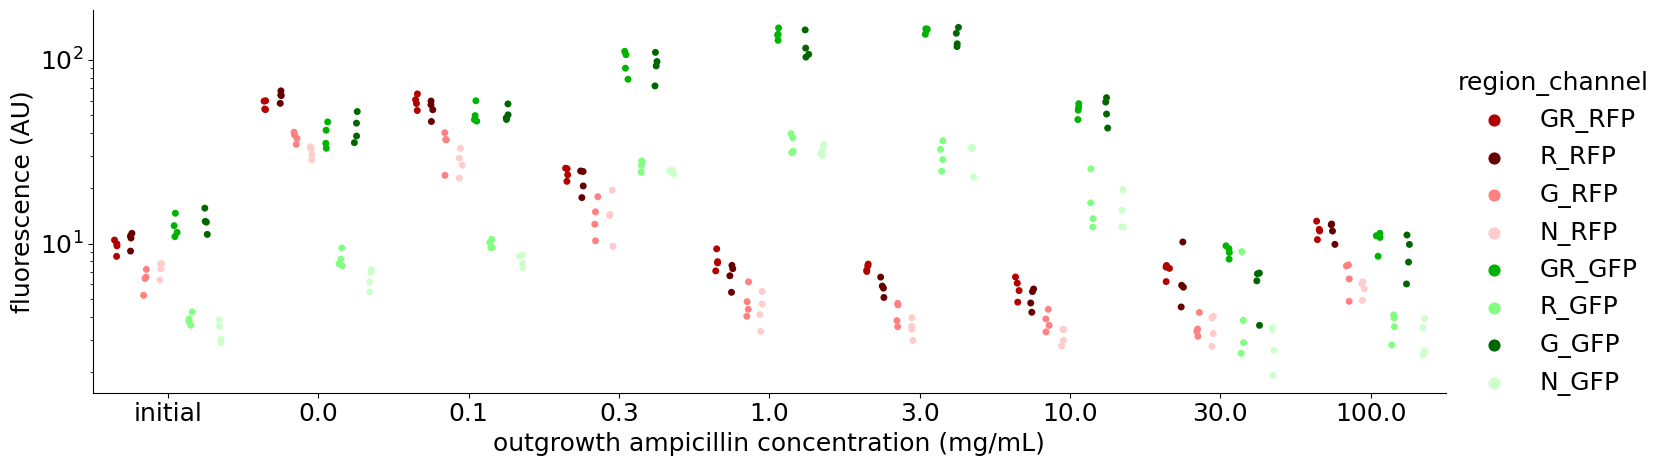

In [16]:
def getPeaks(img,channel): #get peaks in widefield images corresponding to red and green stripes
    trace=savgol_filter(img[100:-100,100:-100,channel].sum(axis=channel),41,3)
    base=np.quantile(trace,0.5)
    height=np.quantile(trace,0.9)
    peaks,properties=find_peaks(trace,height=height,prominence=height-base)
    return peaks+100
def getFluoVals(rimg,gimg,cond=None,boxSize=5,offset=50): #calculate mean fluorescence in R , G, GR, N regions in widefield data
    rPeaks=getPeaks(rimg,channel=0)
    gPeaks=getPeaks(gimg,channel=1)
    GR_RFP=[np.mean(rimg[gPeak-boxSize:gPeak+boxSize,rPeak-boxSize:rPeak+boxSize,0]) for rPeak in rPeaks for gPeak in gPeaks]
    GR_GFP=[np.mean(gimg[gPeak-boxSize:gPeak+boxSize,rPeak-boxSize:rPeak+boxSize,1]) for rPeak in rPeaks for gPeak in gPeaks]
    R_RFP=[np.mean(rimg[gPeak+offset-boxSize:gPeak+offset+boxSize,rPeak-boxSize:rPeak+boxSize,0]) for rPeak in rPeaks for gPeak in gPeaks]
    R_GFP=[np.mean(gimg[gPeak+offset-boxSize:gPeak+offset+boxSize,rPeak-boxSize:rPeak+boxSize,1]) for rPeak in rPeaks for gPeak in gPeaks]
    G_RFP=[np.mean(rimg[gPeak-boxSize:gPeak+boxSize,rPeak+offset-boxSize:rPeak+offset+boxSize,0]) for rPeak in rPeaks for gPeak in gPeaks]
    G_GFP=[np.mean(gimg[gPeak-boxSize:gPeak+boxSize,rPeak+offset-boxSize:rPeak+offset+boxSize,1]) for rPeak in rPeaks for gPeak in gPeaks]
    N_RFP=[np.mean(rimg[gPeak+offset-boxSize:gPeak+offset+boxSize,rPeak+offset-boxSize:rPeak+offset+boxSize,0]) for rPeak in rPeaks for gPeak in gPeaks]
    N_GFP=[np.mean(gimg[gPeak+offset-boxSize:gPeak+offset+boxSize,rPeak+offset-boxSize:rPeak+offset+boxSize,1]) for rPeak in rPeaks for gPeak in gPeaks]
    df=pd.DataFrame([GR_RFP,GR_GFP,R_RFP,R_GFP,G_RFP,G_GFP,N_RFP,N_GFP],columns=['rep1','rep2','rep3','rep4'],
            index=['GR_RFP','GR_GFP','R_RFP','R_GFP','G_RFP','G_GFP','N_RFP','N_GFP']).stack().reset_index().rename(columns={'level_0':'region_channel','level_1':'rep',0:'fluorescence'})
    df[['region','channel']]=df.region_channel.str.split('_',expand=True)
    df=df[['region_channel','region','channel','rep','fluorescence']]
    if cond is not None:
        df['cond']=cond
    return df
wfDataDf=pd.concat([getFluoVals(skimage.io.imread(r"{}".format(row[1].filename_RFP)),skimage.io.imread(r"{}".format(row[1].filename_GFP)),cond=row[1].cond) for row in wfDf.iterrows()])
wfDataDf['outgrowth ampicillin concentration (mg/mL)']=[str(int(cond.split('xamp')[0])/10) if 'xamp' in cond else 'initial' for cond in wfDataDf.cond]
g=sns.catplot(y='fluorescence',x='outgrowth ampicillin concentration (mg/mL)',hue='region_channel',data=wfDataDf,dodge=True,aspect=3,#kind='bar',
            hue_order=['GR_RFP','R_RFP','G_RFP','N_RFP','GR_GFP','R_GFP','G_GFP','N_GFP'],
           palette=[(.7,0,0),(.4,0,0),
                    (1,.5,0.5),(1,.8,.8),
                    (0,.7,0),(.5,1,.5),
                    (0,.4,0),(.8,1,.8)])
g.set(yscale='log')
g.set(ylabel='fluorescence (AU)')
wfDataDf

In [17]:
#statistical tests for wide field data, RFP and GFP increase after 72h

def printTtestMeanStd(array1,array2):
    print([f"{np.around(np.mean(array1),1)}\u00B1{np.around(np.std(array1),1)}",
           f"{np.around(np.mean(array2),1)}\u00B1{np.around(np.std(array2),1)}"])
    print(ttest_ind(array1,array2))

print('compare initial vs post 72h RFP in GR region')
printTtestMeanStd(wfDataDf.loc[(wfDataDf.region_channel=='GR_RFP') & (wfDataDf.cond=='initial'),'fluorescence'],
                  wfDataDf.loc[(wfDataDf.region_channel=='GR_RFP') & (wfDataDf.cond=='0xamp'),'fluorescence'])


print('compare initial vs post 72h GFP in GR region')
printTtestMeanStd(wfDataDf.loc[(wfDataDf.region_channel=='GR_GFP') & (wfDataDf.cond=='initial'),'fluorescence'],
                  wfDataDf.loc[(wfDataDf.region_channel=='GR_GFP') & (wfDataDf.cond=='0xamp'),'fluorescence'])


compare initial vs post 72h RFP in GR region
['9.7±0.7', '56.7±3.0']
TtestResult(statistic=-26.68959007296234, pvalue=1.8267921454154734e-07, df=6.0)
compare initial vs post 72h GFP in GR region
['12.4±1.4', '38.8±5.1']
TtestResult(statistic=-8.643461566151318, pvalue=0.00013213753789145403, df=6.0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


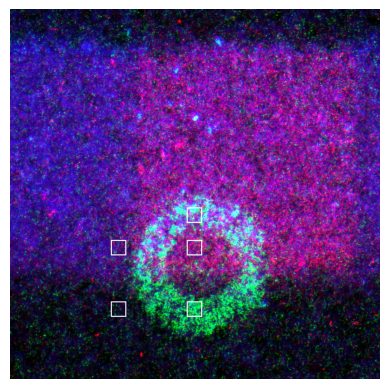

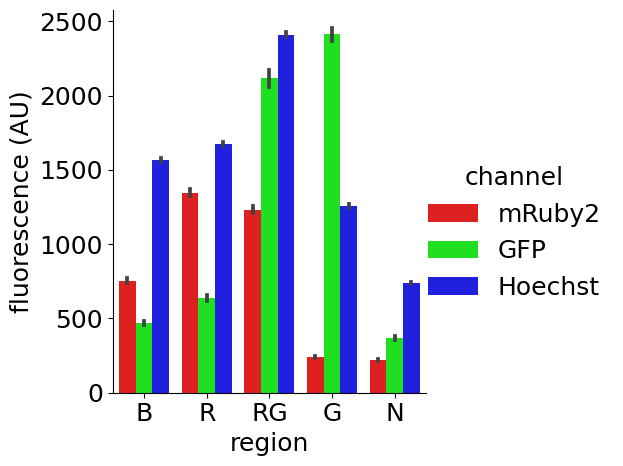

In [18]:
#analyze fluorescence values of biofilm generated using differentation (DS-mRuby2) then succession (SS-GFP)
diffSucc=skimage.io.imread(os.path.join(dataPath,'confocalImaging','differentiationPlusSuccessionExample','294succ250_singleImage2.tiff'))
diffSuccZmean=np.mean(diffSucc,axis=0)
diffSuccZmean2=np.mean(diffSucc,axis=0)

B_lims=(660,300,'B')
R_lims=(660,510,'R')
RG_lims=(570,510,'RG')
G_lims=(830,510,'G')
N_lims=(830,300,'N')

# lims=[B_lims,R_lims,RG_lims,G_lims,N_lims]
boxWidth=20
diffSuccDf=pd.DataFrame()
for lims in [B_lims,R_lims,RG_lims,G_lims,N_lims]:

    rowPos=[lims[0]-boxWidth-1, lims[0]-boxWidth-1, lims[0]+boxWidth+1, lims[0]+boxWidth+1]
    colPos=[lims[1]-boxWidth-1, lims[1]+boxWidth+1, lims[1]+boxWidth+1, lims[1]-boxWidth-1]
    rr, cc = skimage.draw.polygon_perimeter(rowPos, colPos)
    diffSuccZmean2[rr, cc, :]=np.inf

    rowPos=[lims[0]-boxWidth+1, lims[0]-boxWidth+1, lims[0]+boxWidth-1, lims[0]+boxWidth-1]
    colPos=[lims[1]-boxWidth+1, lims[1]+boxWidth-1, lims[1]+boxWidth-1, lims[1]-boxWidth+1]
    rr, cc = skimage.draw.polygon_perimeter(rowPos, colPos)
    diffSuccZmean2[rr, cc, :]=np.inf
    
    rowPos=[lims[0]-boxWidth, lims[0]-boxWidth, lims[0]+boxWidth, lims[0]+boxWidth]
    colPos=[lims[1]-boxWidth, lims[1]+boxWidth, lims[1]+boxWidth, lims[1]-boxWidth]
    rr, cc = skimage.draw.polygon_perimeter(rowPos, colPos)
    diffSuccZmean2[rr, cc, :]=np.inf

    roi=diffSuccZmean[lims[0]-boxWidth:lims[0]+boxWidth,lims[1]-boxWidth:lims[1]+boxWidth,:]
    roiDf=pd.DataFrame(np.reshape(roi,[-1,3]),columns=['mRuby2','GFP','Hoechst']).stack().reset_index().rename(columns={'level_1':'channel',0:'fluorescence (AU)'})
    roiDf['region']=lims[2]
    diffSuccDf=pd.concat([diffSuccDf,roiDf])
imagesc(diffSuccZmean2,quantileLims=(0.01,0.99))
plt.axis('off')
sns.catplot(kind='bar',y='fluorescence (AU)',x='region',hue='channel',data=diffSuccDf,palette=[(1,0,0),(0,1,0),(0,0,1)])

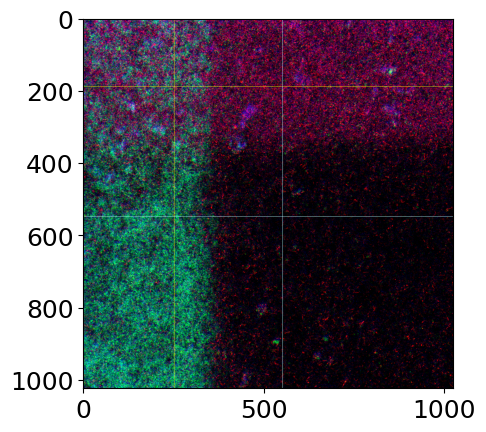

In [19]:
XY1=skimage.io.imread(os.path.join(dataPath,'confocalImaging','successionExample',"XY1.png"))
yellowImg=np.tile([255,255,0],(XY1.shape[0],XY1.shape[1],1))
yellowPosXY1=(XY1==yellowImg).all(axis=2)

XY2=skimage.io.imread(os.path.join(dataPath,'confocalImaging','successionExample',"XY2.png"))
yellowPosXY2=(XY2==yellowImg).all(axis=2)

# XY1[yellowPosXY2,:]=[255,127,255]
XY2[yellowPosXY1,:]=[180,255,255]
plt.imshow(XY2)

skimage.io.imsave(os.path.join(savePath,"orthoView_XYmerge.png"),
                  XY2)


In [20]:
XZ1=skimage.io.imread(os.path.join(dataPath,'confocalImaging','successionExample',"XZ1.png"))
yellowImg=np.tile([255,255,0],(XZ1.shape[0],XZ1.shape[1],1))
yellowPosXZ1=(XZ1==yellowImg).all(axis=2)
XZ1[yellowPosXZ1,:]=[180,255,255]
skimage.io.imsave(os.path.join(savePath,"orthoView_XZ1recolor.png"),
                  XZ1)

In [21]:
YZ1=skimage.io.imread(os.path.join(dataPath,'confocalImaging','successionExample',"YZ1.png"))
yellowImg=np.tile([255,255,0],(YZ1.shape[0],YZ1.shape[1],1))
yellowPosYZ1=(YZ1==yellowImg).all(axis=2)
YZ1[yellowPosYZ1,:]=[180,255,255]
skimage.io.imsave(os.path.join(savePath,"orthoView_YZ1recolor.png"),
                  YZ1)

In [29]:
#collect files corresponding to timelapse imaging of successively patterned biofilms
#note J4K5 is shorthand for IC-RFP, 250 is shorthand for SS-GFP, standalone are monoculture biofilms
#kangrad and ampgrad refer to kanamycin and ampicillin gradients

tiffDf=pd.DataFrame(glob(os.path.join(dataPath,'confocalImaging','successionTimelapse','*','shifted','*.tif*')),columns=['filename'])
tiffDf['expt']=[os.path.normpath(filename).split(os.sep)[-3].rsplit('with',1)[0].rstrip('_|37') for filename in tiffDf.filename]
tiffDf['pos']=[int(os.path.basename(filename).split('.')[0].split('_p')[-1]) for filename in tiffDf.filename]

conds=['pbs',
      '0x',
      '1x',
      '3x',
      '10x',
      '30x',
      '100x',
      '300x',
      '1000x']
reps=[1,2,3]
condRepDf=pd.MultiIndex.from_product([conds,reps]).to_frame().reset_index()[[0,1]].reset_index().rename(columns={'index':'pos',0:'cond',1:'rep'})

tiffDf=tiffDf.merge(condRepDf,on='pos').sort_values(by='filename').reset_index(drop=True)
print(tiffDf.expt.unique())
tiffDf.head()

['250standalone_ampGrad' '250standalone_kanGrad' 'J4K5standalone_ampGrad'
 'J4K5standalone_kanGrad' 'J4K5succ250_ampGrad' 'J4K5succ250_kanGrad']


filename  \
0  E:\biofilmCommunities\data\confocalImaging\successionTimelapse\250standalone_ampGrad_withReplica...   
1  E:\biofilmCommunities\data\confocalImaging\successionTimelapse\250standalone_ampGrad_withReplica...   
2  E:\biofilmCommunities\data\confocalImaging\successionTimelapse\250standalone_ampGrad_withReplica...   
3  E:\biofilmCommunities\data\confocalImaging\successionTimelapse\250standalone_ampGrad_withReplica...   
4  E:\biofilmCommunities\data\confocalImaging\successionTimelapse\250standalone_ampGrad_withReplica...   

                    expt  pos cond  rep  
0  250standalone_ampGrad    0  pbs    1  
1  250standalone_ampGrad    1  pbs    2  
2  250standalone_ampGrad    2  pbs    3  
3  250standalone_ampGrad    3   0x    1  
4  250standalone_ampGrad    4   0x    2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(18, 46, 256, 256, 3)


C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


array([1.55139101e+07, 7.40114953e+00, 8.40358482e+06, 8.71453406e+01])

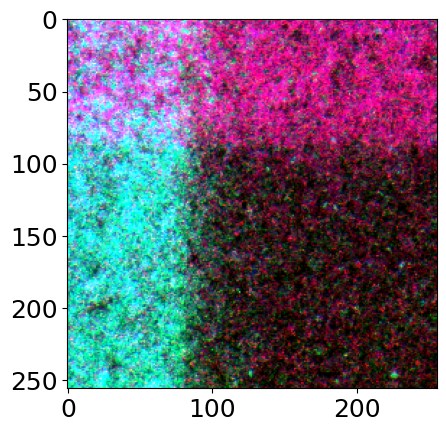

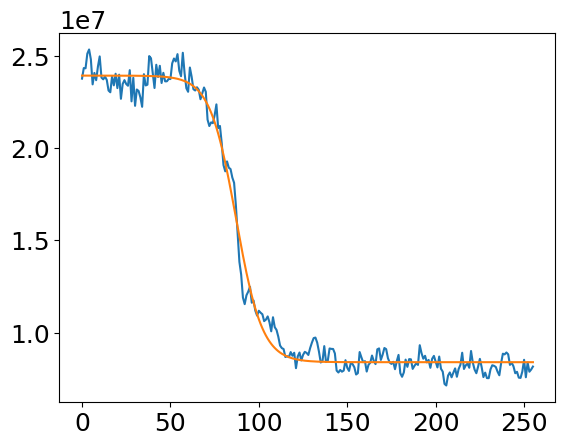

In [25]:


expts=['J4K5succ250_ampGrad']
reps=[1]
conds=['pbs']
tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds),:]
img=readTiff(tiffDfSubset.filename.values[0])
print(img.shape)
plt.figure()
imagesc(np.mean(img[0,:,:,:,:],axis=0))

plt.figure()
params=fitX0(np.sum(img[0,:,:,:,0],axis=(0,2)))
sns.lineplot(range(256),np.sum(img[0,:,:,:,0],axis=(0,2)))
sns.lineplot(range(256),np.asarray([logisticFunc(x,*params) for x in range(256)]))


params

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

R_RFP vs. G_RFP: t-test paired samples, P_val:1.106e-02 t=9.429e+00
GR_GFP vs. R_GFP: t-test paired samples, P_val:3.094e-03 t=1.794e+01
R_GFP vs. G_GFP: t-test paired samples, P_val:1.429e-03 t=-2.642e+01
G_GFP vs. N_GFP: t-test paired samples, P_val:8.213e-04 t=3.487e+01
GR_RFP vs. G_RFP: t-test paired samples, P_val:5.933e-03 t=1.293e+01
R_RFP vs. N_RFP: t-test paired samples, P_val:9.626e-03 t=1.012e+01
GR_RFP vs. N_RFP: t-test paired samples, P_val:3.915e-03 t=1.593e+01
GR_GFP vs. N_GFP: t-test paired samples, P_val:4.817e-03 t=1.436e+01


channel region                   rep  mean fluorescence (AU)       GRfluo  \
0       RFP     GR  J4K5succ250_ampGrad1             1971.933548  2169.483174   
1       RFP      R  J4K5succ250_ampGrad1             1988.239417  2169.483174   
2       RFP      G  J4K5succ250_ampGrad1              747.674765  2169.483174   
3       RFP      N  J4K5succ250_ampGrad1              667.365843  2169.483174   
4       GFP     GR  J4K5succ250_ampGrad1             2978.198174  3006.159516   
5       GFP      R  J4K5succ250_ampGrad1              893.754791  3006.159516   
6       GFP      G  J4K5succ250_ampGrad1             4491.365835  3006.159516   
7       GFP      N  J4K5succ250_ampGrad1              716.121452  3006.159516   
8   Hoescht     GR  J4K5succ250_ampGrad1             3903.781852  4282.258957   
9   Hoescht      R  J4K5succ250_ampGrad1             2376.415948  4282.258957   
10  Hoescht      G  J4K5succ250_ampGrad1             3448.098096  4282.258957   
11  Hoescht      N  J4K5succ250_ampGrad1              980.667470  4282.258957   
12      RFP     GR  J4K5succ250_ampGrad2             2369.410522  2169.483174   
13      RFP      R  J4K5succ250_ampGrad2             2492.114130  2169.483174   
14      RFP      G  J4K5succ250_ampGrad2              766.712922  2169.483174   
15      RFP      N  J4K5succ250_ampGrad2              747.297383  2169.483174   
16      GFP     GR  J4K5succ250_ampGrad2             2783.025478  3006.159516   
17      GFP      R  J4K5succ250_ampGrad2              754.982574  3006.159516   
18      GFP      G  J4K5succ250_ampGrad2             4155.957165  3006.159516   
19      GFP      N  J4K5succ250_ampGrad2              630.215539  3006.159516   
20  Hoescht     GR  J4K5succ250_ampGrad2             4249.195191  4282.258957   
21  Hoescht      R  J4K5succ250_ampGrad2             2648.642183  4282.258957   
22  Hoescht      G  J4K5succ250_ampGrad2             3295.033687  4282.258957   
23  Hoescht      N  J4K5succ250_ampGrad2              940.547643  4282.258957   
24      RFP     GR  J4K5succ250_ampGrad3             2167.105452  2169.483174   
25      RFP      R  J4K5succ250_ampGrad3             2513.506322  2169.483174   
26      RFP      G  J4K5succ250_ampGrad3              757.627261  2169.483174   
27      RFP      N  J4K5succ250_ampGrad3              662.358617  2169.483174   
28      GFP     GR  J4K5succ250_ampGrad3             3257.254896  3006.159516   
29      GFP      R  J4K5succ250_ampGrad3              840.294722  3006.159516   
30      GFP      G  J4K5succ250_ampGrad3             3995.143765  3006.159516   
31      GFP      N  J4K5succ250_ampGrad3              563.795930  3006.159516   
32  Hoescht     GR  J4K5succ250_ampGrad3             4693.799826  4282.258957   
33  Hoescht      R  J4K5succ250_ampGrad3             2911.357461  4282.258957   
34  Hoescht      G  J4K5succ250_ampGrad3             3337.156678  4282.258957   
35  Hoescht      N  J4K5succ250_ampGrad3              972.691435  4282.258957   

    GR-normalized fluorescence  
0                     0.908942  
1                     0.916458  
2                     0.344633  
3                     0.307615  
4                     0.990699  
5                     0.297308  
6                     1.494054  
7                     0.238218  
8                     0.911617  
9                     0.554944  
10                    0.805205  
11                    0.229007  
12                    1.092154  
13                    1.148713  
14                    0.353408  
15                    0.344459  
16                    0.925774  
17                    0.251145  
18                    1.382481  
19                    0.209641  
20                    0.992279  
21                    0.618515  
22                    0.769462  
23                    0.219638  
24                    0.998904  
25                    1.158574  
26                    0.349220  
27                    0.305307  
28                    1.083527  
29              

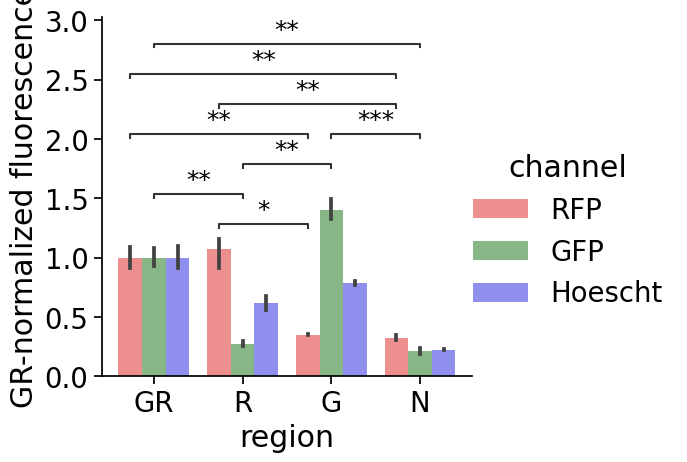

In [26]:
expts=['J4K5succ250_ampGrad']
reps=[1,2,3]
conds=['pbs']
tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds),:]

initFluoDf=pd.concat([getMeanFluorescence(readTiff(filename),rep) for filename,rep in zip(tiffDfSubset.filename,tiffDfSubset.expt+tiffDfSubset.rep.astype(str))])


GRfluos=initFluoDf[initFluoDf.region=='GR'].groupby('channel')['mean fluorescence (AU)'].mean().reset_index().rename(columns={'mean fluorescence (AU)':'GRfluo'})
initFluoDf=initFluoDf.merge(GRfluos,how='left',on='channel')
initFluoDf['GR-normalized fluorescence'] = initFluoDf['mean fluorescence (AU)']/initFluoDf['GRfluo']
with sns.plotting_context("notebook",font_scale=1.8):
    g=sns.catplot(x='region',y='GR-normalized fluorescence',hue='channel',data=initFluoDf,
           kind='bar',palette=['red','green','blue'],alpha=0.5,aspect=1.1,height=5)
    
annot = Annotator(g.ax, [(("GR", "RFP"), ("G", "RFP")),
                        (("GR", "RFP"), ("N", "RFP")),
                        (("R", "RFP"), ("G", "RFP")),
                        (("R", "RFP"), ("N", "RFP")),
                        (("GR", "GFP"), ("R", "GFP")),
                        (("GR", "GFP"), ("N", "GFP")),
                        (("G", "GFP"), ("R", "GFP")),
                        (("G", "GFP"), ("N", "GFP")),
                        ], 
                  data=initFluoDf, x='region', y='mean fluorescence (AU)',hue='channel')
annot.configure(test='t-test_paired', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()
g.savefig(os.path.join(savePath,'successionRegionFluorescenceNormalized.pdf'))

initFluoDf

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

R_RFP vs. G_RFP: t-test paired samples, P_val:1.106e-02 t=9.429e+00
GR_GFP vs. R_GFP: t-test paired samples, P_val:3.094e-03 t=1.794e+01
R_GFP vs. G_GFP: t-test paired samples, P_val:1.429e-03 t=-2.642e+01
G_GFP vs. N_GFP: t-test paired samples, P_val:8.213e-04 t=3.487e+01
GR_RFP vs. G_RFP: t-test paired samples, P_val:5.933e-03 t=1.293e+01
R_RFP vs. N_RFP: t-test paired samples, P_val:9.626e-03 t=1.012e+01
GR_RFP vs. N_RFP: t-test paired samples, P_val:3.915e-03 t=1.593e+01
GR_GFP vs. N_GFP: t-test paired samples, P_val:4.817e-03 t=1.436e+01


channel region                   rep  mean fluorescence (AU)
0     RFP     GR  J4K5succ250_ampGrad1             1971.933548
1     RFP      R  J4K5succ250_ampGrad1             1988.239417
2     RFP      G  J4K5succ250_ampGrad1              747.674765
3     RFP      N  J4K5succ250_ampGrad1              667.365843
4     GFP     GR  J4K5succ250_ampGrad1             2978.198174

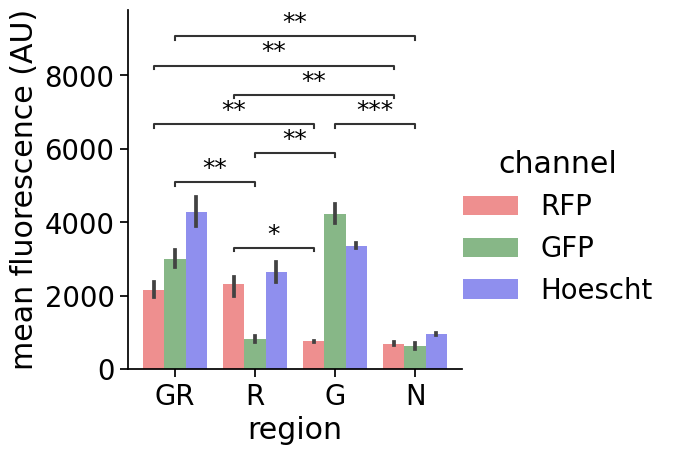

In [27]:
expts=['J4K5succ250_ampGrad']
reps=[1,2,3]
conds=['pbs']
tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds),:]

initFluoDf=pd.concat([getMeanFluorescence(readTiff(filename),rep) for filename,rep in zip(tiffDfSubset.filename,tiffDfSubset.expt+tiffDfSubset.rep.astype(str))])
with sns.plotting_context("notebook",font_scale=1.8):
    g=sns.catplot(x='region',y='mean fluorescence (AU)',hue='channel',data=initFluoDf,
           kind='bar',palette=['red','green','blue'],alpha=0.5,aspect=1.1,height=5)
    
annot = Annotator(g.ax, [(("GR", "RFP"), ("G", "RFP")),
                        (("GR", "RFP"), ("N", "RFP")),
                        (("R", "RFP"), ("G", "RFP")),
                        (("R", "RFP"), ("N", "RFP")),
                        (("GR", "GFP"), ("R", "GFP")),
                        (("GR", "GFP"), ("N", "GFP")),
                        (("G", "GFP"), ("R", "GFP")),
                        (("G", "GFP"), ("N", "GFP")),
                        ], 
                  data=initFluoDf, x='region', y='mean fluorescence (AU)',hue='channel')
annot.configure(test='t-test_paired', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

g.savefig(os.path.join(savePath,'successionRegionFluorescence.pdf'))
initFluoDf.head()


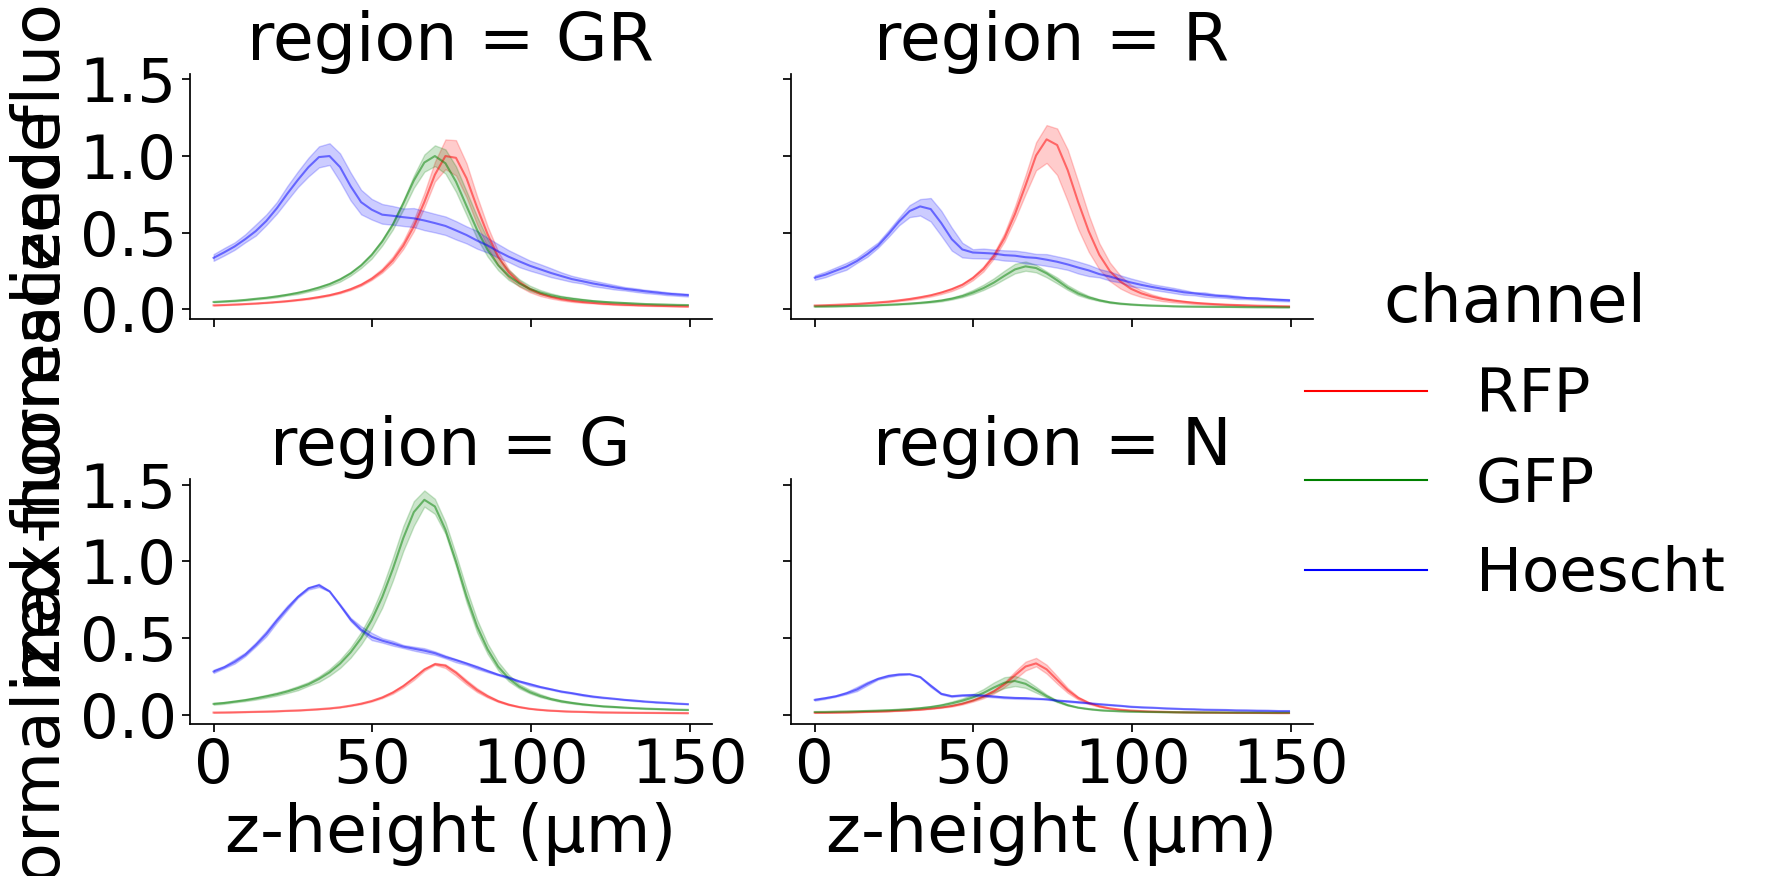

In [28]:
def getZMeansMultiRegion(img,rep,xlims=None,ylims=None,boxSize=50,imgSizeUm=850): # get Z slice means of fluorescence across G,GR, R, and N regions
    imgSize=img.shape[-2]
    umPerPixel=imgSizeUm/imgSize

    if len(img.shape)==5:
        frame0=np.squeeze(img[0,:,:,:,:])
    else:
        frame0=img
    if xlims is None and ylims is None:
        redBoundary=fitX0(np.sum(frame0[:,:,:,0],axis=(0,2)))[-1]
        greenBoundary=fitX0(np.sum(frame0[:,:,:,1],axis=(0,1)))[-1]
        xlimsGR=np.round([(greenBoundary-boxSize)/2,
                        (greenBoundary+boxSize)/2]).astype(int)
        ylimsGR=np.round([(redBoundary-boxSize)/2,
                        (redBoundary+boxSize)/2]).astype(int)
        xlimsG=np.round([(greenBoundary-boxSize)/2,
                        (greenBoundary+boxSize)/2]).astype(int)
        ylimsG=np.round([(redBoundary+imgSize-boxSize)/2,
                        (redBoundary+imgSize+boxSize)/2]).astype(int)
        xlimsR=np.round([(greenBoundary+imgSize-boxSize)/2,
                        (greenBoundary+imgSize+boxSize)/2]).astype(int)
        ylimsR=np.round([(redBoundary-boxSize)/2,
                        (redBoundary+boxSize)/2]).astype(int)
        xlimsN=np.round([(greenBoundary+imgSize-boxSize)/2,
                        (greenBoundary+imgSize+boxSize)/2]).astype(int)
        ylimsN=np.round([(redBoundary+imgSize-boxSize)/2,
                        (redBoundary+imgSize+boxSize)/2]).astype(int)
    elif ylims is None:
        ylims=xlims
    dfGR=pd.DataFrame(np.mean(frame0[:,ylimsGR[0]:ylimsGR[1],xlimsGR[0]:xlimsGR[1],:],axis=(1,2)),columns=['RFP','GFP','Hoescht']).stack().reset_index().rename(columns={'level_0':'z-height (μm)','level_1':'channel',0:'mean fluorescence (AU)'})
    dfGR['region']='GR'
    dfG=pd.DataFrame(np.mean(frame0[:,ylimsG[0]:ylimsG[1],xlimsG[0]:xlimsG[1],:],axis=(1,2)),columns=['RFP','GFP','Hoescht']).stack().reset_index().rename(columns={'level_0':'z-height (μm)','level_1':'channel',0:'mean fluorescence (AU)'})
    dfG['region']='G'
    dfR=pd.DataFrame(np.mean(frame0[:,ylimsR[0]:ylimsR[1],xlimsR[0]:xlimsR[1],:],axis=(1,2)),columns=['RFP','GFP','Hoescht']).stack().reset_index().rename(columns={'level_0':'z-height (μm)','level_1':'channel',0:'mean fluorescence (AU)'})
    dfR['region']='R'
    dfN=pd.DataFrame(np.mean(frame0[:,ylimsN[0]:ylimsN[1],xlimsN[0]:xlimsN[1],:],axis=(1,2)),columns=['RFP','GFP','Hoescht']).stack().reset_index().rename(columns={'level_0':'z-height (μm)','level_1':'channel',0:'mean fluorescence (AU)'})
    dfN['region']='N'
    df=pd.concat([dfGR,dfR,dfG,dfN])
    df['z-height (μm)']=df['z-height (μm)']*umPerPixel
    df['rep']=rep
    
    return df[['channel','region','rep','z-height (μm)','mean fluorescence (AU)']]

expts=['J4K5succ250_ampGrad']
reps=[1,2,3]
conds=['pbs']
tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds),:]
imgSizeUm=850
boxSize=50

initZMeansDf=pd.concat([getZMeansMultiRegion(readTiff(filename),rep) for filename,rep in zip(tiffDfSubset.filename,tiffDfSubset.rep.astype(int))]).reset_index(drop=True)
fluoMaxes=initZMeansDf[initZMeansDf.region=='GR'].groupby(['channel','z-height (μm)'])['mean fluorescence (AU)'].mean().unstack().T.max().reset_index().rename(columns={0:'maxFluo'})
initZMeansDf=initZMeansDf.merge(fluoMaxes,how='left',on='channel')
initZMeansDf['max-normalized fluorescence'] = initZMeansDf['mean fluorescence (AU)']/initZMeansDf['maxFluo']
initZMeansDf


with sns.plotting_context("notebook",font_scale=4):
    g=sns.relplot(y='max-normalized fluorescence',x='z-height (μm)',hue='channel',col='region',col_wrap=2,
                  data=initZMeansDf,aspect=1.4,
                 palette=['red','green','blue'],alpha=0.5,kind='line')
g.savefig(os.path.join(savePath,'successionZFluorescence_maxNormMultiRegion.pdf'))


In [3]:
diffTiffDf=pd.DataFrame(glob(os.path.join(dataPath,'confocalImaging','differentiationControls','*.tif*')),columns=['filename'])
diffTiffDf['cond']=[os.path.basename(filename).split('.')[0][:-1] for filename in diffTiffDf.filename]
diffTiffDf['rep']=[int(os.path.basename(filename).split('.')[0][-1]) for filename in diffTiffDf.filename]

diffTiffDf.head()

filename  \
0     E:\biofilmCommunities\data\confocalImaging\differentiationControls\withahlwithillum1.tif   
1     E:\biofilmCommunities\data\confocalImaging\differentiationControls\withahlwithillum2.tif   
2     E:\biofilmCommunities\data\confocalImaging\differentiationControls\withahlwithillum3.tif   
3  E:\biofilmCommunities\data\confocalImaging\differentiationControls\withahlwithoutillum1.tif   
4  E:\biofilmCommunities\data\confocalImaging\differentiationControls\withahlwithoutillum2.tif   

                  cond  rep  
0     withahlwithillum    1  
1     withahlwithillum    2  
2     withahlwithillum    3  
3  withahlwithoutillum    1  
4  withahlwithoutillum    2

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RB_RFP vs. B_RFP: t-test paired samples, P_val:2.238e-02 t=6.571e+00
B_Hoescht vs. N_Hoescht: t-test paired samples, P_val:2.043e-03 t=2.209e+01
RB_RFP vs. N_RFP: t-test paired samples, P_val:7.052e-03 t=1.185e+01
RB_Hoescht vs. N_Hoescht: t-test paired samples, P_val:1.240e-03 t=2.837e+01


channel region  rep  mean fluorescence (AU)
0      RFP     RB    1             2759.515687
1      RFP      B    1             1437.770461
2      RFP      N    1              307.179643
6  Hoescht     RB    1             3403.822139
7  Hoescht      B    1             3078.217565

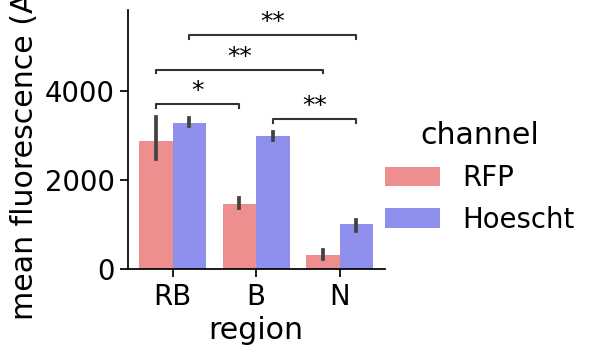

In [4]:
reps=[1,2,3]
conds=['withahlwithillum'] #use the data with AHL and illumination
diffTiffDfSubset=diffTiffDf.loc[diffTiffDf.rep.isin(reps)&diffTiffDf.cond.isin(conds),:]

diffFluoDf=pd.concat([getDiffMeanFluorescence(readTiff(filename,numFrames=1,imSize=512),rep) for filename,rep in zip(diffTiffDfSubset.filename,diffTiffDfSubset.rep)])
diffFluoDf=diffFluoDf.loc[diffFluoDf.channel!='GFP',:]
with sns.plotting_context("notebook",font_scale=1.8):
    g=sns.catplot(x='region',y='mean fluorescence (AU)',hue='channel',data=diffFluoDf,
           kind='bar',palette=['red','blue'],alpha=0.5,
                 aspect=1.2,height=4)

annot = Annotator(g.ax, [(("RB", "RFP"), ("B", "RFP")),
                        (("RB", "RFP"), ("N", "RFP")),
                        (("RB", "Hoescht"), ("N", "Hoescht")),
                        (("B", "Hoescht"), ("N", "Hoescht")),
                        ], 
                  data=diffFluoDf, x='region', y='mean fluorescence (AU)',hue='channel')
annot.configure(test='t-test_paired', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()
g.savefig(os.path.join(savePath,'differentiationRegionFluorescence.pdf'))
diffFluoDf.head()

C:\Users\Xiaofan\AppData\Local\Temp\ipykernel_12416\703940039.py:13: RuntimeWarning: invalid value encountered in divide
  return plt.imshow((img-vmin)/(vmax-vmin),**kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


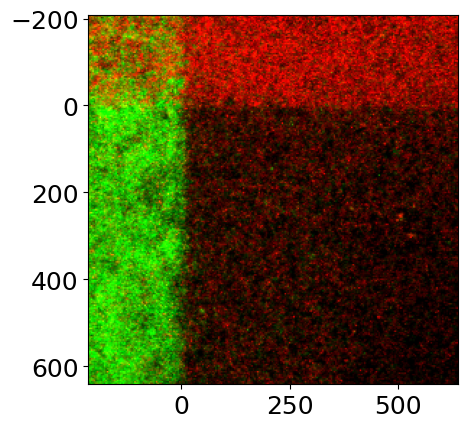

In [54]:
expts=['J4K5succ250_kanGrad']
reps=[1]
conds=['pbs']
numFrames=6
ylims=[0,256]
xlims=[45,135]
numPixels=256
imSize=850

umPerPixel=imSize/numPixels

tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds),:]
img=readTiff(tiffDfSubset.filename.values[0])
initImg=np.squeeze(np.mean(img[0,:,:,:,:],axis=0))

rBoundary=fitX0(np.sum(initImg[:,:,0],axis=1))
gBoundary=fitX0(np.sum(initImg[:,:,1],axis=0))
initImg[:,:,2]=0
imagesc(initImg, quantileLims=[0.01,0.99],
        extent=umPerPixel*np.array([-gBoundary[-1],numPixels-gBoundary[-1],numPixels-rBoundary[-1],-rBoundary[-1],]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

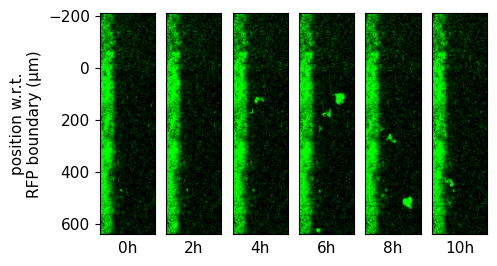

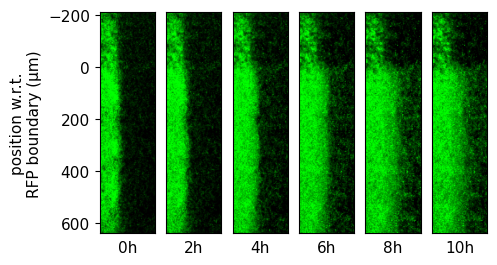

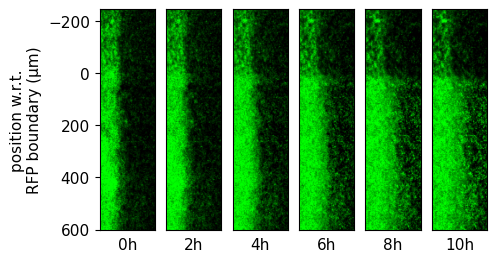

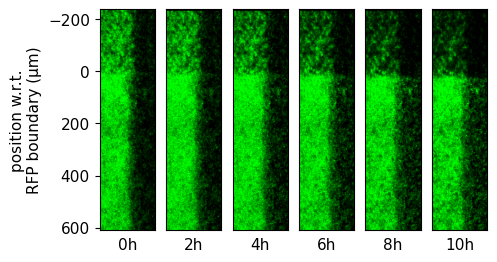

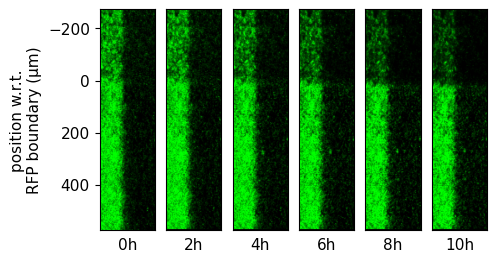

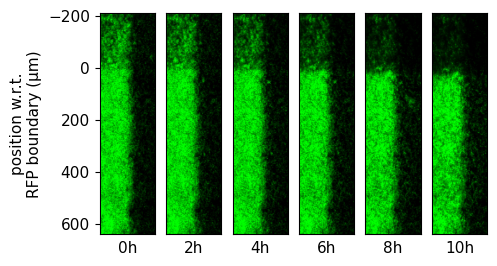

In [56]:
expts=['J4K5succ250_kanGrad']
reps=[1]
conds=['pbs','0x','1x','3x','10x','100x']
numFrames=6
ylims=[0,256]
xlims=[45,135]
numPixels=256
imSize=850

umPerPixel=imSize/numPixels

for cond in conds:
    tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin([cond]),:]
    img=readTiff(tiffDfSubset.filename.values[0])
    imgZsum=np.mean(img,axis=1)
    redBoundary=fitX0(np.sum(imgZsum[0,:,:,0],axis=1))[-1]
    fig,ax=plt.subplots(1,numFrames,figsize=(5,5),gridspec_kw={'wspace':0.2})
    for frame in range(numFrames):
        greenSlice=imgZsum[frame,ylims[0]:ylims[1],xlims[0]:xlims[1],:]
        greenSlice[:,:,[0,2]]=0
        imagesc(greenSlice,ax=ax[frame],aspect=4,extent=[0,850,umPerPixel*(numPixels-1-redBoundary),umPerPixel*(-redBoundary)])
        if frame>-0:
            ax[frame].set(xticklabels="",yticklabels="",xticks=[],yticks=[])
        else:
            ax[frame].set(xticklabels="",xticks=[],ylabel="position rel. RFP biofilm boundary (μm)")
            ax[frame].set_ylabel("position w.r.t.\nRFP boundary (μm)",fontsize=11)

            ax[frame].tick_params(axis='both', which='major', labelsize=11)
        ax[frame].set_xlabel(f"{2*frame}h",rotation=0,position=(.5,0),labelpad=5,fontsize=11)
        if cond=='0x':
            plt.savefig(os.path.join(savePath,'growthImageExample.pdf'))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

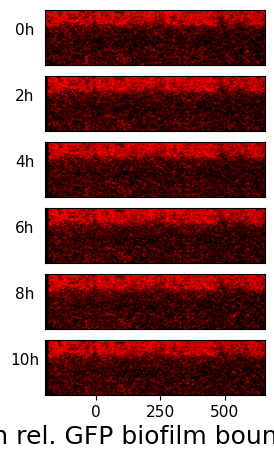

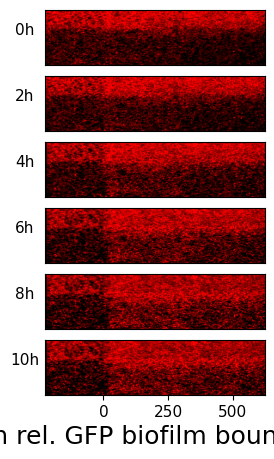

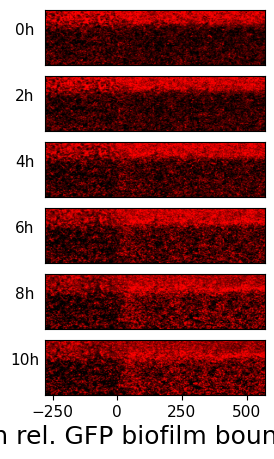

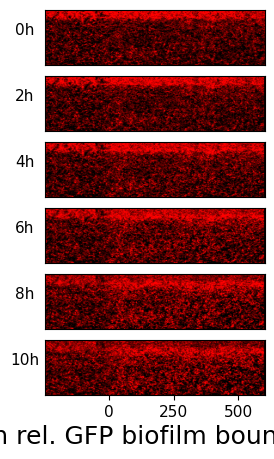

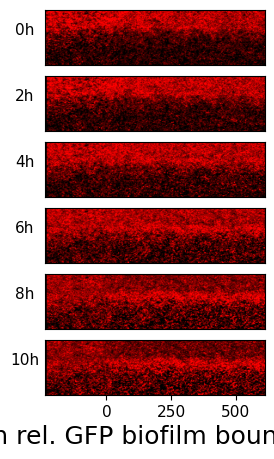

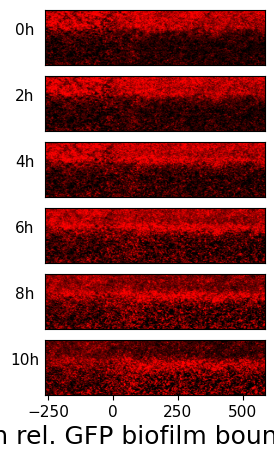

In [57]:
expts=['J4K5succ250_kanGrad']
reps=[3]
conds=['pbs','0x','1x','3x','10x','100x']
numFrames=6
xlims=[0,256]
ylims=[45,135]
numPixels=256
imSize=850

umPerPixel=imSize/numPixels

for cond in conds:
    tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin([cond]),:]
    img=readTiff(tiffDfSubset.filename.values[0])
    imgZsum=np.mean(img,axis=1)
    greenBoundary=fitX0(np.sum(imgZsum[0,:,:,1],axis=0))[-1]
    fig,ax=plt.subplots(numFrames,1,figsize=(5,5),gridspec_kw={'wspace':0.2})
    for frame in range(numFrames):
        redSlice=imgZsum[frame,ylims[0]:ylims[1],xlims[0]:xlims[1],:]
        redSlice[:,:,[1,2]]=0
        imagesc(redSlice,ax=ax[frame],aspect=.25,extent=[umPerPixel*(-greenBoundary),umPerPixel*(numPixels-1-greenBoundary),0,850])
        if frame<numFrames-1:
            ax[frame].set(xticklabels="",yticklabels="",xticks=[],yticks=[])
        else:
            ax[frame].set(yticklabels="",yticks=[],xlabel="position rel. GFP biofilm boundary (μm)")
            ax[frame].set_ylabel("position w.r.t.\nGFP boundary (μm)",fontsize=11)

            ax[frame].tick_params(axis='both', which='major', labelsize=11)
        ax[frame].set_ylabel(f"{2*frame}h",rotation=0,position=(.05,0.5),labelpad=15,fontsize=11)
        if cond=='0x':
            plt.savefig(os.path.join(savePath,'growthImageExampleRFP.pdf'))


x         y  type time      xShift
0   0.000000  0.688922  data   0h -258.962699
1   3.320312  0.717197  data   0h -255.642387
2   6.640625  0.745374  data   0h -252.322074
3   9.960938  0.758459  data   0h -249.001762
4  13.281250  0.784634  data   0h -245.681449

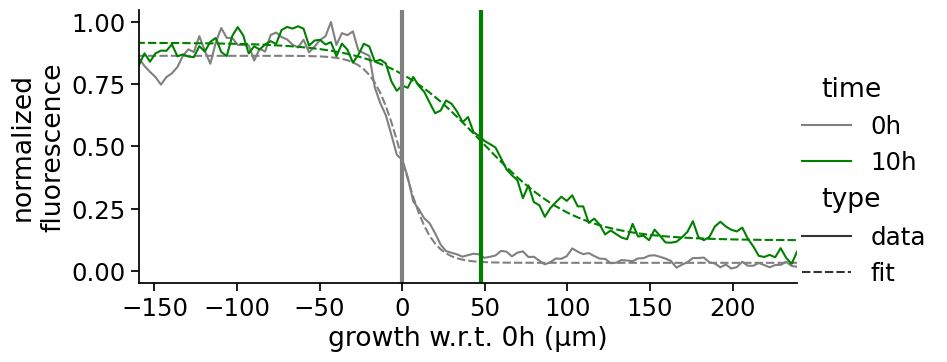

In [58]:
expts=['J4K5succ250_kanGrad']
reps=[1]
conds=['0x']
numFrames=6
ylims=[150,180]
xlims=[30,150]
umPerPixel=850/256

tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds),:]
img=readTiff(tiffDfSubset.filename.values[0])
imgZsum=np.mean(img,axis=1)
imgZsum.shape
linePlotDf=pd.DataFrame([])
for frame in [0,5]:
    greenSlice=imgZsum[frame,ylims[0]:ylims[1],:,:]
    greenSlice[:,:,[0,2]]=0

    params,newLinePlotDf=getLinePlotDf(greenSlice[:,:,1],time=f"{2*frame}h")
    linePlotDf=pd.concat([linePlotDf,newLinePlotDf]).reset_index(drop=True)
    if frame==0:
        initX0=params[-1]
linePlotDf['xShift']=linePlotDf['x']-initX0

with sns.plotting_context("notebook",font_scale=1.6):
    g=sns.relplot(kind='line',x='xShift',y='y',data=linePlotDf,hue='time',style='type',palette=['grey','green'],aspect=2,height=4)
    g.ax.set_xlabel("growth w.r.t. 0h (μm)")
    g.ax.set_ylabel("normalized\nfluorescence")
    g.ax.set_xlim(umPerPixel*np.asarray(xlims)-initX0)
    g.ax.axvline(x=params[-1]-initX0,color='green',lw=3)
    g.ax.axvline(x=0,color='grey',lw=3)
    g.savefig(os.path.join(savePath,'growthLogisticFitExample.pdf'))


linePlotDf.head()


x         y  type time      xShift
0   0.000000  0.649633  data   0h -236.495517
1   3.320312  0.629058  data   0h -233.175204
2   6.640625  0.754789  data   0h -229.854892
3   9.960938  0.866081  data   0h -226.534579
4  13.281250  0.737470  data   0h -223.214267

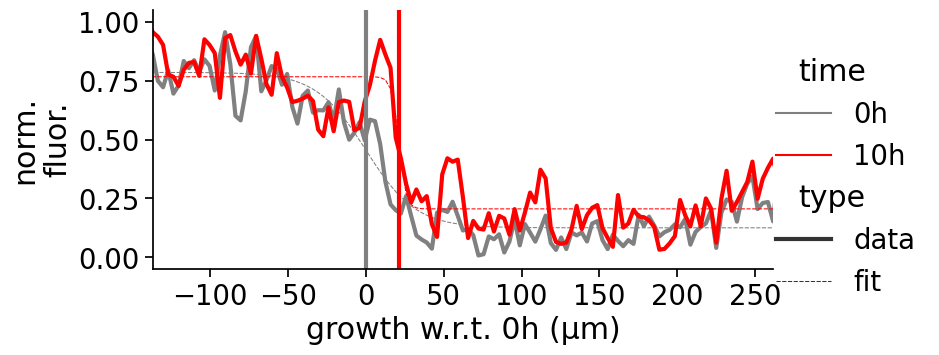

In [14]:
expts=['J4K5succ250_kanGrad']
reps=[3]
conds=['0x']
numFrames=6
xlims=[175,200]
xlims=[15,40]
ylims=[30,150]
umPerPixel=850/256

tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds),:]
img=readTiff(tiffDfSubset.filename.values[0])
imgZsum=np.mean(img,axis=1)
imgZsum.shape
linePlotDf=pd.DataFrame([])
for frame in [0,5]:
    redSlice=imgZsum[frame,:,xlims[0]:xlims[1],:]
    redSlice[:,:,[1,2]]=0

    params,newLinePlotDf=getLinePlotDf(redSlice[:,:,0].T,time=f"{2*frame}h")
    linePlotDf=pd.concat([linePlotDf,newLinePlotDf]).reset_index(drop=True)
    if frame==0:
        initX0=params[-1]
linePlotDf['xShift']=linePlotDf['x']-initX0

with sns.plotting_context("notebook",font_scale=1.8):
    g=sns.relplot(kind='line',x='xShift',y='y',data=linePlotDf,hue='time',size='type',style='type',palette=['grey','red'],aspect=2,height=4)
    g.ax.set_xlabel("growth w.r.t. 0h (μm)")
    g.ax.set_ylabel("norm.\nfluor.")
    g.ax.set_xlim(umPerPixel*np.asarray(ylims)-initX0)
    g.ax.axvline(x=params[-1]-initX0,color='red',lw=3)
    g.ax.axvline(x=0,color='grey',lw=3)
    g.savefig(os.path.join(savePath,'growthLogisticFitExampleRFP.pdf'))

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

linePlotDf.head()
# sns.lineplot(x=x-initX0,y=logisticFunc(x=x,a=params[0],c=params[1],x0=params[-1]),ax=ax[frame*2+1],color="green",alpha=0.5)
# sns.despine()
# ax[frame*2+1].axvline(x=params[-1]-initX0,color='green')
# ax[frame*2+1].lines[1].set_linestyle("--")
# ax[frame*2].set(xticklabels="",yticklabels="",xticks=[],yticks=[])
# ax[frame*2].set_ylabel(f"{2*frame}h",rotation=0,position=(0,-.5),labelpad=20)
# ax[frame*2+1].set(yticklabels="",yticks=[],xlim=umPerPixel*np.asarray(xlims)-initX0)
# if frame!=numFrames-1:
#     ax[frame*2+1].set(xticklabels="")
# else:
#     ax[frame*2+1].set(xlabel="shift from 0h (μm)")

In [60]:
expts=['J4K5succ250_kanGrad','J4K5succ250_ampGrad']

reps=[1,2,3]
conds=['0x','1x','3x','10x','30x','100x']
# conds=['0x','1x','3x','10x','30x','100x','300x','1000x']

numFrames=6
umPerPixel=850/256

slicePosList=np.arange(-150,500,50) #positions in microns to take slice relative to init X0 boundary
# slicePosList=np.asarray([-100,0,400]) #positions in microns to take slice relative to init X0 boundary
sliceWidth=80 #width of each slice to take in microns, 80um~24pixels in 256x256 images
halfSliceLengthInPixels=256 #use the entire length of the image (256 pixels) to do the fit

tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds),:]
df=pd.DataFrame([])
for row in tiffDfSubset.iterrows():
    img=readTiff(row[1].filename)
    expt=row[1].expt
    cond=row[1].cond
    rep=row[1].rep
    imgZsum=np.mean(img,axis=1)

    frameNum=0
    channel=0

    redInitX0=fitX0(np.sum(imgZsum[0,:,:,0],axis=1))[-1]
    greenInitX0=fitX0(np.sum(imgZsum[0,:,:,1],axis=0))[-1]
    greenSlicePosListInPixels=list(zip(np.ceil(redInitX0+(slicePosList-sliceWidth/2)/umPerPixel).astype(int),
                                       np.floor(redInitX0+(slicePosList+sliceWidth/2)/umPerPixel).astype(int)))
    redSlicePosListInPixels=list(zip(np.ceil(greenInitX0+(slicePosList-sliceWidth/2)/umPerPixel).astype(int),
                                     np.floor(greenInitX0+(slicePosList+sliceWidth/2)/umPerPixel).astype(int)))
#     print(rep,redSlicePosListInPixels)
    prevGreenX0=None
    prevRedX0=None
    for frameNum in range(numFrames):
        if frameNum==0:
            newDf=pd.DataFrame({'expt':expt,
                                'cond':cond,
                                'rep':rep,
                                'time (h)':2*frameNum,
                                'position (μm)':slicePosList,
                                'redPixelRange':[f"{xlim1}-{xlim2}" for xlim1,xlim2 in redSlicePosListInPixels],
                                'greenPixelRange':[f"{ylim1}-{ylim2}" for ylim1,ylim2 in greenSlicePosListInPixels],
                                'greenX0':[fitSlice(imgZsum,ylim1,ylim2,frameNum,channel=1)[-1] for ylim1,ylim2 in greenSlicePosListInPixels],
                                'redX0':[fitSlice(imgZsum,xlim1,xlim2,frameNum,channel=0)[-1] for xlim1,xlim2 in redSlicePosListInPixels]})
            initGreenX0=newDf.greenX0
            initRedX0=newDf.redX0
            newDf['GFP shift (μm)']=0
            newDf['RFP shift (μm)']=0
            df=pd.concat([df,newDf])
        else:
            newDf=pd.DataFrame({'expt':expt,
                                'cond':cond,
                                'rep':rep,
                                'time (h)':2*frameNum,
                                'position (μm)':slicePosList,
                                'redPixelRange':[f"{xlim1}-{xlim2}" for xlim1,xlim2 in redSlicePosListInPixels],
                                'greenPixelRange':[f"{ylim1}-{ylim2}" for ylim1,ylim2 in greenSlicePosListInPixels],
                                'greenX0':[fitSlice(imgZsum,ylim1,ylim2,frameNum,channel=1,xlims=[int(np.round(prevX0/umPerPixel-halfSliceLengthInPixels)),int(np.round(prevX0/umPerPixel+halfSliceLengthInPixels))])[-1] for (ylim1,ylim2),prevX0 in zip(greenSlicePosListInPixels,prevGreenX0)],
                                'redX0':[fitSlice(imgZsum,xlim1,xlim2,frameNum,channel=0,xlims=[int(np.round(prevX0/umPerPixel-halfSliceLengthInPixels)),int(np.round(prevX0/umPerPixel+halfSliceLengthInPixels))])[-1] for (xlim1,xlim2),prevX0 in zip(redSlicePosListInPixels,prevRedX0)]})
            newDf['GFP shift (μm)']=newDf.greenX0-initGreenX0
            newDf['RFP shift (μm)']=newDf.redX0-initRedX0
            df=pd.concat([df,newDf])
        prevGreenX0=newDf.greenX0
        prevRedX0=newDf.redX0

df=df.reset_index(drop=True)
ampCondDict=dict(zip([f"{intCond}x" for intCond in np.sort([int(cond.strip('x')) for cond in df.cond.unique()])],
                     [0]+list(np.power(10,np.arange(-1,1.5,.5)))))
kanCondDict=dict(zip([f"{intCond}x" for intCond in np.sort([int(cond.strip('x')) for cond in df.cond.unique()])],
                     [0]+list(0.5*np.power(10,np.arange(-1,1.5,.5)))))
df['[Ampicillin] (mg/mL)']=df.cond.map(ampCondDict)
df['[Kanamycin] (mg/mL)']=df.cond.map(kanCondDict)
df.loc[df.expt.str.contains('kanGrad'),'[Ampicillin] (mg/mL)']=np.nan
df.loc[df.expt.str.contains('ampGrad'),'[Kanamycin] (mg/mL)']=np.nan
df.head()

expt cond  rep  time (h)  position (μm) redPixelRange  \
0  J4K5succ250_ampGrad   0x    1         0           -150         25-48   
1  J4K5succ250_ampGrad   0x    1         0           -100         40-63   
2  J4K5succ250_ampGrad   0x    1         0            -50         55-78   
3  J4K5succ250_ampGrad   0x    1         0              0         70-93   
4  J4K5succ250_ampGrad   0x    1         0             50        85-108   

  greenPixelRange     greenX0       redX0  GFP shift (μm)  RFP shift (μm)  \
0           17-40  272.399955  203.942488             0.0             0.0   
1           32-55  274.871785  233.285372             0.0             0.0   
2           47-70  272.168635  233.673312             0.0             0.0   
3           62-85  271.855968  256.421133             0.0             0.0   
4          77-100  273.929695  246.545603             0.0             0.0   

   [Ampicillin] (mg/mL)  [Kanamycin] (mg/mL)  
0                   0.0                  NaN  
1                   0.0                  NaN  
2                   0.0                  NaN  
3                   0.0                  NaN  
4                   0.0                  NaN

In [61]:
df.to_csv(os.path.join(savePath,'df.csv'),index=False)

In [6]:
df=pd.read_csv(os.path.join(savePath,'df.csv'))
df.head()

expt cond  rep  time (h)  position (μm) redPixelRange  \
0  J4K5succ250_ampGrad   0x    1         0           -150         25-48   
1  J4K5succ250_ampGrad   0x    1         0           -100         40-63   
2  J4K5succ250_ampGrad   0x    1         0            -50         55-78   
3  J4K5succ250_ampGrad   0x    1         0              0         70-93   
4  J4K5succ250_ampGrad   0x    1         0             50        85-108   

  greenPixelRange     greenX0       redX0  GFP shift (μm)  RFP shift (μm)  \
0           17-40  272.399955  203.942488             0.0             0.0   
1           32-55  274.871785  233.285372             0.0             0.0   
2           47-70  272.168635  233.673312             0.0             0.0   
3           62-85  271.855968  256.421133             0.0             0.0   
4          77-100  273.929695  246.545603             0.0             0.0   

   [Ampicillin] (mg/mL)  [Kanamycin] (mg/mL)  
0                   0.0                  NaN  
1                   0.0                  NaN  
2                   0.0                  NaN  
3                   0.0                  NaN  
4                   0.0                  NaN

In [64]:
def printRes(res,var='time'):
    print(f"var={var}, coeffs={np.around(res.params[var],1)}\u00B1{np.around(res.bse[var],1)}, pval={res.pvalues[var]}")


In [65]:

for condConcentration in [('0x','0mg/mL'),('1x','0.1mg/mL'),('10x','1mg/mL'),('30x','3mg/mL'),('100x','10mg/mL')]:
    print('\n')
    for position in [-150,0,400]:
        print('\n')
        compDf=df[(df.expt=='J4K5succ250_ampGrad')&(df.cond==condConcentration[0])&(df['position (μm)']==position)]
        compDf.columns=[col.split()[0] for col in compDf.columns]
        
        
        print(f'RFP growth rate test at position {position} microns, ampicillin concentration {condConcentration[1]}')
        mod = smf.ols(formula='RFP  ~ time', data=compDf)
        
        res = mod.fit()
        printRes(res)

        print(f'GFP growth rate test at position {position} microns, ampicillin concentration {condConcentration[1]}')
        mod = smf.ols(formula='GFP  ~ time', data=compDf)
        
        res = mod.fit()
        
        printRes(res)





RFP growth rate test at position -150 microns, ampicillin concentration 0mg/mL
var=time, coeffs=2.2±0.4, pval=2.467161673065822e-05
GFP growth rate test at position -150 microns, ampicillin concentration 0mg/mL
var=time, coeffs=1.9±0.2, pval=1.9583976404031906e-07


RFP growth rate test at position 0 microns, ampicillin concentration 0mg/mL
var=time, coeffs=4.4±0.3, pval=5.5859946655013194e-11
GFP growth rate test at position 0 microns, ampicillin concentration 0mg/mL
var=time, coeffs=2.3±0.2, pval=6.819253209030487e-11


RFP growth rate test at position 400 microns, ampicillin concentration 0mg/mL
var=time, coeffs=4.3±0.4, pval=2.065823446172838e-09
GFP growth rate test at position 400 microns, ampicillin concentration 0mg/mL
var=time, coeffs=4.5±0.3, pval=5.341802220473665e-12




RFP growth rate test at position -150 microns, ampicillin concentration 0.1mg/mL
var=time, coeffs=0.6±0.3, pval=0.03917043711778418
GFP growth rate test at position -150 microns, ampicillin concentratio

In [66]:
compDf=df[(df.expt=='J4K5succ250_ampGrad')&(df.cond=='0x')&(df['time (h)']>0)&(df['position (μm)'].isin([-150,400]))]
compDf.columns=[col.split()[0] for col in compDf.columns]
compDf['positionString']=compDf['position'].map({-150:'inner',0:'boundary',400:'outer'})
print('LMM to compare RFP growth between inner -150um position and outer +400um position')
md = smf.mixedlm("RFP ~ positionString", compDf, groups=compDf["time"])

mdf = md.fit()

printRes(mdf,var="positionString[T.outer]")

print('LMM to compare GFP growth between inner -150um position and outer +400um position')
md = smf.mixedlm("GFP ~ positionString", compDf, groups=compDf["time"])

mdf = md.fit()
printRes(mdf,var="positionString[T.outer]")



LMM to compare RFP growth between inner -150um position and outer +400um position
var=positionString[T.outer], coeffs=10.1±2.6, pval=8.067119836634897e-05
LMM to compare GFP growth between inner -150um position and outer +400um position
var=positionString[T.outer], coeffs=15.2±2.1, pval=1.4766951083843887e-13


In [67]:
compDf=df[(df.expt=='J4K5succ250_ampGrad')&(df.cond=='0x')&(df['time (h)']>0)&(df['position (μm)'].isin([-150,0,400]))]
compDf.columns=[col.split()[0] for col in compDf.columns]
compDf['positionString']=compDf['position'].map({-150:'inner',0:'boundary',400:'outer'})

md = smf.mixedlm("RFP ~ positionString", compDf, groups=compDf["time"])
print('LMM to test at 0mg/mL ampicillin RFP growth is not faster in 0um position than both -150um position and +400um position')

mdf = md.fit()
printRes(mdf,var="positionString[T.inner]")
printRes(mdf,var="positionString[T.outer]")

LMM to test at 0mg/mL ampicillin RFP growth is not faster in 0um position than both -150um position and +400um position
var=positionString[T.inner], coeffs=-11.1±2.3, pval=1.5957336358247036e-06
var=positionString[T.outer], coeffs=-1.0±2.3, pval=0.6762359766763284


In [69]:
compDf=df[(df.expt=='J4K5succ250_ampGrad')&(df.cond=='10x')&(df['time (h)']>0)&(df['position (μm)'].isin([-150,0,400]))]
compDf.columns=[col.split()[0] for col in compDf.columns]
compDf['positionString']=compDf['position'].map({-150:'inner',0:'boundary',400:'outer'})

md = smf.mixedlm("RFP ~ positionString", compDf, groups=compDf["time"])
print('LMM to test at 1mg/mL ampicillin RFP growth is faster in 0um position than both -150um position and +400um position')

mdf = md.fit()
printRes(mdf,var="positionString[T.inner]")
printRes(mdf,var="positionString[T.outer]")


LMM to test at 1mg/mL ampicillin RFP growth is faster in 0um position than both -150um position and +400um position
var=positionString[T.inner], coeffs=-8.3±1.9, pval=8.104783191108586e-06
var=positionString[T.outer], coeffs=-10.9±1.9, pval=6.120262050242944e-09


In [70]:
compDf=df[(df.expt=='J4K5succ250_ampGrad')&(df.cond.isin(['0x','30x','100x']))&(df['time (h)']>0)&(df['position (μm)'].isin([400]))]
compDf.columns=[col.split()[0] for col in compDf.columns]

md = smf.mixedlm("GFP ~ cond", compDf, groups=compDf["time"])
print('LMM to test GFP growth at +400um position for 0mg/mL ampicillin vs 3 and 10mg/mL')

mdf = md.fit()
printRes(mdf,var="cond[T.30x]")
printRes(mdf,var="cond[T.100x]")


LMM to test GFP growth at +400um position for 0mg/mL ampicillin vs 3 and 10mg/mL
var=cond[T.30x], coeffs=-6.9±3.2, pval=0.034070980498650774
var=cond[T.100x], coeffs=-26.7±3.2, pval=1.7075969328726715e-16


In [71]:
compDf=df[(df.expt=='J4K5succ250_ampGrad')&(df.cond.isin(['0x','1x','3x','10x','30x','100x']))&(df['time (h)']>0)&(df['position (μm)'].isin([0]))]
compDf.columns=[col.split()[0] for col in compDf.columns]

md = smf.mixedlm("GFP ~ cond", compDf, groups=compDf["time"])
print('LMM to test GFP growth at 0um position for 0mg/mL ampicillin vs 0.1mg/mL')

mdf = md.fit()
printRes(mdf,var="cond[T.1x]")
printRes(mdf,var="cond[T.3x]")
printRes(mdf,var="cond[T.10x]")
printRes(mdf,var="cond[T.30x]")
printRes(mdf,var="cond[T.100x]")


LMM to test GFP growth at 0um position for 0mg/mL ampicillin vs 0.1mg/mL
var=cond[T.1x], coeffs=6.6±1.8, pval=0.0002654110524249529
var=cond[T.3x], coeffs=3.3±1.8, pval=0.07188368573659225
var=cond[T.10x], coeffs=4.8±1.8, pval=0.007943751305114941
var=cond[T.30x], coeffs=-3.6±1.8, pval=0.04960471860345268
var=cond[T.100x], coeffs=-10.8±1.8, pval=2.7844571306755815e-09


In [395]:
compDf=df[(df.expt=='J4K5succ250_ampGrad')&(df.cond.isin(['0x','1x']))&(df['time (h)']>0)&(df['position (μm)'].isin([0]))]
compDf.columns=[col.split()[0] for col in compDf.columns]

md = smf.mixedlm("GFP ~ cond", compDf, groups=compDf["time"])
print('LMM to test GFP growth at 0um position for 0mg/mL ampicillin vs 0.1mg/mL')

mdf = md.fit()
printRes(mdf,var="cond[T.1x]")




LMM to test GFP growth at 0um position for 0mg/mL ampicillin vs 0.1mg/mL
var=cond[T.1x], coeffs=6.6±1.2, pval=1.0308458284715149e-08


In [5]:
def fitSimSlice(img,lim1,lim2,channel,xlims=None,umPerPixel=850/64):
    if channel==1:
        imgSlice=img[lim1:lim2,:]
    elif channel==0:
        imgSlice=img[:,lim1:lim2].T
    else:
        return None
    if xlims is None:
        xlims=[0,imgSlice.shape[1]]
    y=np.sum(imgSlice[:,xlims[0]:xlims[1]],axis=0)
    x=umPerPixel*np.arange(*xlims)
    x=x[y>0]
    y=y[y>0]
    ymin=np.min(y)
    ymax=np.max(y)
    params=fitX0(x=x,y=y)
    return params
def minZero(mat):
    mat[mat<0]=0
    return mat
class biofilmSimulate:
    def __init__(self,
                exptName="simulation",
                xSize=64,
                dt=6,
                simTimeInSeconds=36000,
                simSizeInMicrons=850,
                initAmp=1,#initial ampicillin concentration in mg/mL (note in paper this is converted to molar basis)
                initNutr=2,#initial nutrients in mg/mL
                bmMax=6,#carrying capacity of biomass density, in pg/um^2 (dry biomass, 1 cell~0.3pg)
                initDarkBmMean=None,#how much biomass density to initialize unilluminated regions in pg/um^2 (dry biomass, 1 cell~0.3pg)
                initIllumBmMean=3,#how much biomass to initialize illuminated regions in pg/um^2 (dry biomass, 1 cell~0.3pg)
                fractionIllum=0.25,#what fraction of simulation area is illuminated for each strain


                 

                gammaBm=5.6e-6,#death rate of biomass in s^-1
                gammaBla=9.6e-6,#decay rate of betalactamase in s^-1
                gammaAmp=7.4e-6,#inherent decay rate of ampicillin in s^-1 (not mediated by bla)
                 
                D_nutr=600,#diffusivity of nutrients in um^2/s
                D_bm=0.149,#diffusivity of biomass in um^2/s
                D_amp=400,#diffusivity of ampicillin in um^2/s
                 
                muMax=4.8e-5, #max growth rate in s^-1
                 
                K_nutr=0.004,#nutrient concentration at half max growth rate in mg/mL glucose
                yield_nutr=0.632,#nutrient to biomass conversion yield in (pg/um^2 biomass density)/(mg/mL nutrient) (h=2mm already incorporated in here, this is Yh in the paper)
                K_ampR=0.00094,#hill constant for ampicillin inhibition of red cells (note in paper this is converted to molar basis)
                K_ampG=0.482,#hill constant for ampicillin inhibition of green cells (note in paper this is converted to molar basis)
                h_amp=0.75,#hill coefficient for ampicillin inhibition of red and green cells
                Kd_bla=0.0012,#dissociation constant for beta lactamase degradation rxn of amp in mg/mL (note in paper this is converted to molar basis)
                Kcat_bla=4.2,#catalytic constant for beta lactamase degradation rxn of amp in s^-1
                Kprod_bla=1.53e-09,#production rate of beta lactamase by green cells in (mg/mL)/(pg/um^2)/s%. Note that in the paper we uses molar basis units for p are molecules/cell/s, this term includes a conversion to mass basis using h, m_cell, MW_bla to convert
                Kdif=2.86e-05,#rate constant of diffusion of ampicillin into biofilm, in s^-1 (this is k_eq in paper)

                ):
        if initDarkBmMean is None:
            initDarkBmMean=initIllumBmMean/100
        warnings.filterwarnings('ignore')
        self.params=locals()
        self.params.pop('self')
        self.params['nSteps']=int(simTimeInSeconds/dt)
        self.params['cond']=f"{int(float('%.1g' % (initAmp*10)))}x"
        self.params['dx']=simSizeInMicrons/xSize
        self.Dmat=-2*np.diag(np.ones(xSize))+np.diag(np.ones(xSize-1),1)+np.diag(np.ones(xSize-1),-1)
        self.Dmat[0,0]=-1
        self.Dmat[-1,-1]=-1
        initBm1d=initDarkBmMean+(initIllumBmMean-initDarkBmMean)*np.exp(-(np.arange(xSize)-xSize*fractionIllum))/(1+np.exp(-(np.arange(xSize)-xSize*fractionIllum)))

        self.Gbm=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.Gbm[:,:,0]=np.tile(initBm1d,(xSize,1))
        self.Rbm=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.Rbm[:,:,0]=np.tile(initBm1d,(xSize,1)).T
        self.mu_R=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.mu_G=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.ampMedia=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.ampMedia[:,:,0]=initAmp
        self.ampBiofilm=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.bla=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.nutr=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32)
        self.nutr[:,:,0]=initNutr
        self.greenCmap=LinearSegmentedColormap.from_list("greenCmap",[[0,0,0],[0,1,0]])
        self.redCmap=LinearSegmentedColormap.from_list("redCmap",[[0,0,0],[1,0,0]])
        warnings.filterwarnings('default')
        
    def simulate(self,nSteps=None):
        warnings.filterwarnings('ignore')
        if nSteps is None:
            nSteps=self.params['nSteps']
        for step in np.arange(nSteps):
            self.mu_R[:,:,step]=self.params['muMax']*np.divide(self.nutr[:,:,step],(self.nutr[:,:,step]+self.params['K_nutr']))*(1-(self.Rbm[:,:,step]+self.Gbm[:,:,step])/self.params['bmMax'])*np.divide(np.power(self.params['K_ampR'],self.params['h_amp']),(np.power(self.ampBiofilm[:,:,step],self.params['h_amp'])+np.power(self.params['K_ampR'],self.params['h_amp'])))
            self.mu_G[:,:,step]=self.params['muMax']*np.divide(self.nutr[:,:,step],(self.nutr[:,:,step]+self.params['K_nutr']))*(1-(self.Rbm[:,:,step]+self.Gbm[:,:,step])/self.params['bmMax'])*np.divide(np.power(self.params['K_ampG'],self.params['h_amp']),(np.power(self.ampBiofilm[:,:,step],self.params['h_amp'])+np.power(self.params['K_ampG'],self.params['h_amp'])))
            self.Rbm[:,:,step+1]=self.Rbm[:,:,step]*(1+self.params['dt']*(self.mu_R[:,:,step]-self.params['gammaBm']))+(self.params['dt']/np.power(self.params['dx'],2))*self.params['D_bm']*(np.matmul(self.Dmat,self.Rbm[:,:,step])+np.matmul(self.Rbm[:,:,step],self.Dmat));
            self.Gbm[:,:,step+1]=self.Gbm[:,:,step]*(1+self.params['dt']*(self.mu_G[:,:,step]-self.params['gammaBm']))+(self.params['dt']/np.power(self.params['dx'],2))*self.params['D_bm']*(np.matmul(self.Dmat,self.Gbm[:,:,step])+np.matmul(self.Gbm[:,:,step],self.Dmat));
            
            self.ampMedia[:,:,step+1]=self.ampMedia[:,:,step]+self.params['dt']*(-self.params['Kdif']*(self.ampMedia[:,:,step]-self.ampBiofilm[:,:,step])-self.params['gammaAmp']*self.ampMedia[:,:,step])
            self.ampMedia[:,:,step+1]=np.mean(self.ampMedia[:,:,step+1]);
            self.ampBiofilm[:,:,step+1]=self.ampBiofilm[:,:,step]+self.params['dt']*(self.params['Kdif']*(self.ampMedia[:,:,step]-self.ampBiofilm[:,:,step])-self.params['Kcat_bla']*self.bla[:,:,step]*np.divide(self.ampBiofilm[:,:,step],(self.params['Kd_bla']+self.ampBiofilm[:,:,step]))-self.params['gammaAmp']*self.ampBiofilm[:,:,step])
            self.bla[:,:,step+1]=self.bla[:,:,step]+self.params['dt']*(self.params['Kprod_bla']*self.Gbm[:,:,step]-self.params['gammaBla']*self.bla[:,:,step]);
            self.nutr[:,:,step+1]=self.nutr[:,:,step]-(self.params['dt']/self.params['yield_nutr'])*(self.Rbm[:,:,step]*self.mu_R[:,:,step]+self.Gbm[:,:,step]*self.mu_G[:,:,step])
            self.nutr[:,:,step+1]=np.mean(self.nutr[:,:,step+1]);

            self.ampMedia[:,:,step+1]=minZero(self.ampMedia[:,:,step+1]);
            self.ampBiofilm[:,:,step+1]=minZero(self.ampBiofilm[:,:,step+1]);
            self.bla[:,:,step+1]=minZero(self.bla[:,:,step+1]);
            self.nutr[:,:,step+1]=minZero(self.nutr[:,:,step+1]);
            self.Rbm[:,:,step+1]=minZero(self.Rbm[:,:,step+1]);
            self.Gbm[:,:,step+1]=minZero(self.Gbm[:,:,step+1]);
        warnings.filterwarnings('default')
    
    def showPlots(self,steps=None):
        warnings.filterwarnings('ignore')
        if steps is None:
            steps=(np.arange(0,self.params['simTimeInSeconds']+1,7200)/self.params['dt']).astype(int)
        fig,axs=plt.subplots(nrows=len(steps),ncols=8,figsize=(16,2*len(steps)),squeeze=False)
        for ind,step in enumerate(steps):
            imagesc(self.Rbm[:,:,step],ax=axs[ind,0],cmap=self.redCmap,lims=(0,np.max(self.Rbm)))
            imagesc(self.Gbm[:,:,step],ax=axs[ind,1],cmap=self.greenCmap,lims=(0,np.max(self.Gbm)))
            imagesc(self.mu_R[:,:,step],ax=axs[ind,2],cmap=self.redCmap,lims=(0,np.max(self.mu_R)))
            imagesc(self.mu_G[:,:,step],ax=axs[ind,3],cmap=self.greenCmap,lims=(0,np.max(self.mu_G)))
            imagesc(self.bla[:,:,step],ax=axs[ind,4],cmap='gray',lims=(0,np.max(self.bla)))
            imagesc(self.ampMedia[:,:,step],ax=axs[ind,5],cmap='gray',lims=(0,np.max(self.ampMedia)))
            imagesc(self.ampBiofilm[:,:,step],ax=axs[ind,6],cmap='gray',lims=(0,np.max(self.ampBiofilm)))
            imagesc(self.nutr[:,:,step],ax=axs[ind,7],cmap='gray',lims=(0,np.max(self.nutr)))
        axs[0,0].set_title('Rbm',fontdict={'fontsize': 12})
        axs[0,1].set_title('Gbm',fontdict={'fontsize': 12})
        axs[0,2].set_title('mu_R',fontdict={'fontsize': 12})
        axs[0,3].set_title('mu_G',fontdict={'fontsize': 12})
        axs[0,4].set_title('bla',fontdict={'fontsize': 12})
        axs[0,5].set_title('ampMedia',fontdict={'fontsize': 12})
        axs[0,6].set_title('ampBiofilm',fontdict={'fontsize': 12})
        axs[0,7].set_title('nutr',fontdict={'fontsize': 12})
        for axs2 in axs:
            for ax in axs2:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_yticks([])
                ax.set_xticks([])
        warnings.filterwarnings('default')
        
    def getFits(self, steps=None,positions=np.arange(-150,500,50),sliceWidth=80):
        if steps is None:
            steps=(np.arange(0,self.params['simTimeInSeconds']+1,7200)/self.params['dt']).astype(int)
        initBoundary=self.params['simSizeInMicrons']*self.params['fractionIllum']
        slicePosListInPixels=list(zip(np.ceil((initBoundary+positions-sliceWidth/2)/self.params['dx']).astype(int),
                                           np.floor((initBoundary+positions+sliceWidth/2)/self.params['dx']).astype(int)))
        df=pd.DataFrame()
        for step in steps:
            newDf=pd.DataFrame({'expt':self.params['exptName'],
                                'cond':self.params['cond'],
                                'rep':1,
                                'time (h)':int(step*self.params['dt']/3600),
                                'position (μm)':positions,
                                'redPixelRange':[f"{xlim1}-{xlim2}" for xlim1,xlim2 in slicePosListInPixels],
                                'greenPixelRange':[f"{ylim1}-{ylim2}" for ylim1,ylim2 in slicePosListInPixels],
                                'greenX0':[fitSimSlice(self.Gbm[:,:,step],lim1,lim2,channel=1)[-1] for lim1,lim2 in slicePosListInPixels],
                                'redX0':[fitSimSlice(self.Rbm[:,:,step],lim1,lim2,channel=0)[-1] for lim1,lim2 in slicePosListInPixels]})
            if step==0:
                initGreenX0=newDf.greenX0
                initRedX0=newDf.redX0
                newDf['GFP shift (μm)']=0
                newDf['RFP shift (μm)']=0
            else:
                newDf['GFP shift (μm)']=newDf.greenX0-initGreenX0
                newDf['RFP shift (μm)']=newDf.redX0-initRedX0
            df=pd.concat([df,newDf])

        df=df.reset_index(drop=True)
        df['[Ampicillin] (mg/mL)']=self.params['initAmp']
        df['[Kanamycin] (mg/mL)']=np.nan
        return df
    
def simAmpGrad(makePlots=True,saveName=None,includeLegend=False,fontScale=1.8,fullDf=None,**kwargs):
    initAmps=df['[Ampicillin] (mg/mL)'].dropna().unique()
    if fullDf is None:
        fullDf=df[df.expt.str.contains('amp')].copy()
        for initAmp in initAmps:
            testSim=biofilmSimulate(initAmp=initAmp,**kwargs)
            testSim.simulate()
            simDf=testSim.getFits()
            fullDf=pd.concat([fullDf,simDf])
            del testSim
    else:
        pass
    if makePlots:
        with sns.plotting_context("notebook",font_scale=fontScale):

            plotPositions=[-150,400]
            plotConds=['0x','10x','100x']

            gPalette=[(0,0.5,0),(0,1,0),(.5,1,.5)]
            rPalette=[(.5,0,0),(1,0,0),(1,.5,.5)]
            if includeLegend:
                fig,axs=plt.subplots(2,3,figsize=(24,8))
            else:
                fig,axs=plt.subplots(2,3,figsize=(12,8))

            plotDf=fullDf[(fullDf.cond=='0x')&(fullDf['position (μm)'].isin(plotPositions))]
            plotDf['expt']=plotDf.expt.map({'J4K5succ250_ampGrad':'experiment','simulation':'simulation'})
            g=sns.lineplot(x='time (h)',y='RFP shift (μm)',hue='position (μm)',style='expt',palette=rPalette[:len(plotPositions)],
                        data=plotDf.reset_index(drop=True),ax=axs[0,0],legend=includeLegend)
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))
            g=sns.lineplot(x='time (h)',y='GFP shift (μm)',hue='position (μm)',style='expt',palette=gPalette[:len(plotPositions)],
                        data=plotDf.reset_index(drop=True),ax=axs[1,0],legend=includeLegend)
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))

            plotDf=fullDf[(fullDf['time (h)']==8)&(fullDf['cond'].isin(plotConds))]
            plotDf['expt']=plotDf.expt.map({'J4K5succ250_ampGrad':'experiment','simulation':'simulation'})
            g=sns.lineplot(x='position (μm)',y='RFP shift (μm)',hue='[Ampicillin] (mg/mL)',style='expt',palette=[(.5,0,0),(1,0,0),(1,.5,.5)],
                        data=plotDf.reset_index(drop=True),ax=axs[0,1],legend=includeLegend)
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))

            g=sns.lineplot(x='position (μm)',y='GFP shift (μm)',hue='[Ampicillin] (mg/mL)',style='expt',palette=[(0,0.5,0),(0,1,0),(.5,1,.5)],
                        data=plotDf.reset_index(drop=True),ax=axs[1,1],legend=includeLegend)
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))


            plotPositions=[0,400]

            plotDf=fullDf[(fullDf['time (h)']==8)&(fullDf['position (μm)'].isin(plotPositions))]
            plotDf['expt']=plotDf.expt.map({'J4K5succ250_ampGrad':'experiment','simulation':'simulation'})
            g=sns.lineplot(x='[Ampicillin] (mg/mL)',y='RFP shift (μm)',hue='position (μm)',style='expt',palette=rPalette[:len(plotPositions)],
                        data=plotDf.reset_index(drop=True),ax=axs[0,2],legend=includeLegend)
            g.set_xscale('symlog', linthresh=0.1)
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))

            g=sns.lineplot(x='[Ampicillin] (mg/mL)',y='GFP shift (μm)',hue='position (μm)',style='expt',palette=gPalette[:len(plotPositions)],
                        data=plotDf.reset_index(drop=True),ax=axs[1,2],legend=includeLegend)
            g.set_xscale('symlog', linthresh=0.1)
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))

            titleString='_'.join([f"{key}={value}" for key, value in kwargs.items()])
            fig.suptitle(titleString,fontsize=12)
            fig.tight_layout()
            if saveName is not None:
                fig.savefig(saveName)
    return fullDf
def getAmpGradDiffs(fullDf):
    compareDf=fullDf[fullDf.expt=='J4K5succ250_ampGrad'].groupby(['cond','time (h)','position (μm)'])[['GFP shift (μm)','RFP shift (μm)','[Ampicillin] (mg/mL)']].mean().reset_index().merge(fullDf.loc[fullDf.expt=='simulation',['cond','time (h)','position (μm)','GFP shift (μm)','RFP shift (μm)']],on=(['cond','time (h)','position (μm)',]),suffixes=(' - expt',' - sim'))
    diff=np.mean(np.concatenate((np.abs(compareDf['GFP shift (μm) - expt']-compareDf['GFP shift (μm) - sim']),np.abs(compareDf['RFP shift (μm) - expt']-compareDf['RFP shift (μm) - sim']))))
    diff0x=np.mean(np.concatenate((np.abs(compareDf.loc[compareDf.cond=='0x','GFP shift (μm) - expt']-compareDf.loc[compareDf.cond=='0x','GFP shift (μm) - sim']),np.abs(compareDf.loc[compareDf.cond=='0x','RFP shift (μm) - expt']-compareDf.loc[compareDf.cond=='0x','RFP shift (μm) - sim']))))
    return diff, diff0x

C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


expt cond  rep  time (h)  position (μm) redPixelRange  \
0   simulation  10x    1         0           -150           2-7   
1   simulation  10x    1         0           -100          6-11   
2   simulation  10x    1         0            -50         10-15   
3   simulation  10x    1         0              0         13-19   
4   simulation  10x    1         0             50         17-22   
..         ...  ...  ...       ...            ...           ...   
73  simulation  10x    1        10            250         32-37   
74  simulation  10x    1        10            300         36-41   
75  simulation  10x    1        10            350         40-45   
76  simulation  10x    1        10            400         44-49   
77  simulation  10x    1        10            450         47-52   

   greenPixelRange     greenX0       redX0  GFP shift (μm)  RFP shift (μm)  \
0              2-7  212.499999  212.499999        0.000000        0.000000   
1             6-11  212.499999  212.499999        0.000000        0.000000   
2            10-15  212.499999  212.499999        0.000000        0.000000   
3            13-19  212.500001  212.500001        0.000000        0.000000   
4            17-22  212.499999  212.499999        0.000000        0.000000   
..             ...         ...         ...             ...             ...   
73           32-37  258.245056  218.042018       45.745056        5.542019   
74           36-41  258.429500  217.853164       45.929500        5.353165   
75           40-45  258.480307  217.831633       45.980308        5.331633   
76           44-49  258.491210  217.829172       45.991211        5.329173   
77           47-52  258.493243  217.829018       45.993244        5.329019   

    [Ampicillin] (mg/mL)  [Kanamycin] (mg/mL)  
0                      1                  NaN  
1                      1                  NaN  
2                      1                  NaN  
3                      1                  NaN  
4                      1                  NaN  
..                   ...                  ...  
73                     1                  NaN  
74                     1                  NaN  
75                     1                  NaN  
76                     1                  NaN  
77                     1                  NaN  

[78 rows x 13 columns]

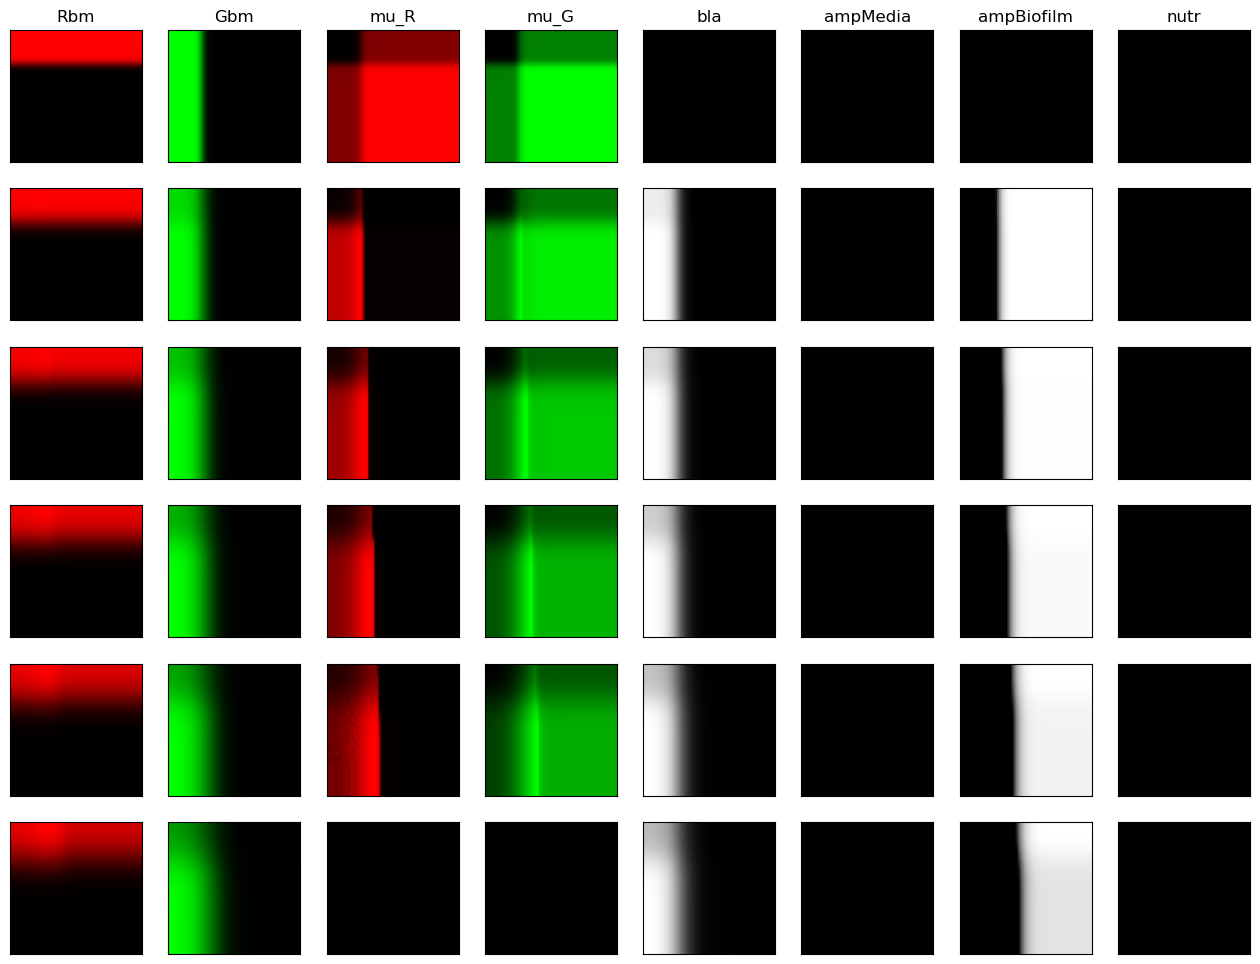

In [109]:
testSim=biofilmSimulate()
testSim.simulate()
testSim.showPlots()
simDf=testSim.getFits()
simDf

In [7]:
fullDf=simAmpGrad(muMax=4.8e-5,D_bm=.149,bmMax=6,initIllumBmMean=3,Kprod_bla=1.53e-09, Kdif=2.86e-05,
           makePlots=False,includeLegend='brief',fontScale=1.8,saveName=None)

includeLegend='full'
fontScale=1.666666666666666667
saveName=os.path.join(savePath,'growthDotPlots.pdf')
with sns.plotting_context("notebook",font_scale=fontScale):

    plotPositions=[-150,400]
    plotConds=['0x','10x','100x']

    gPalette=[(0,0.5,0),(0,1,0),(.5,1,.5)]
    rPalette=[(.5,0,0),(1,0,0),(1,.5,.5)]
    if includeLegend:
        fig,axs=plt.subplots(2,3,figsize=(25,9))
    else:
        fig,axs=plt.subplots(2,3,figsize=(12,8))

    plotDf=fullDf[(fullDf.cond=='0x')&(fullDf['position (μm)'].isin(plotPositions))]
    plotDf['expt']=plotDf.expt.map({'J4K5succ250_ampGrad':'experiment','simulation':'simulation'})
    g=sns.scatterplot(x='time (h)',y='RFP shift (μm)',hue='position (μm)',style='expt',palette=rPalette[:len(plotPositions)],
                data=plotDf[plotDf.expt=='experiment'].reset_index(drop=True),ax=axs[0,0],legend=includeLegend)
    g2=sns.lineplot(x='time (h)',y='RFP shift (μm)',hue='position (μm)',style='expt',palette=rPalette[:len(plotPositions)],
                data=plotDf[plotDf.expt=='simulation'].reset_index(drop=True),ax=axs[0,0],legend=includeLegend)
    g.set_xticks([0,2,4,6,8,10])
    if includeLegend:
        g.legend(bbox_to_anchor=(1.05, 1))
    g.set_ylim([-2,48])

    g=sns.scatterplot(x='time (h)',y='GFP shift (μm)',hue='position (μm)',style='expt',palette=gPalette[:len(plotPositions)],
                data=plotDf[plotDf.expt=='experiment'].reset_index(drop=True),ax=axs[1,0],legend=includeLegend)
    g2=sns.lineplot(x='time (h)',y='GFP shift (μm)',hue='position (μm)',style='expt',palette=gPalette[:len(plotPositions)],
                data=plotDf[plotDf.expt=='simulation'].reset_index(drop=True),ax=axs[1,0],legend=includeLegend)
    g.set_xticks([0,2,4,6,8,10])
    if includeLegend:
        g.legend(bbox_to_anchor=(1.05, 1))
    g.set_ylim([-2,48])

    plotDf=fullDf[(fullDf['time (h)']==8)&(fullDf['cond'].isin(plotConds))]
    plotDf['expt']=plotDf.expt.map({'J4K5succ250_ampGrad':'experiment','simulation':'simulation'})
    g=sns.scatterplot(x='position (μm)',y='RFP shift (μm)',hue='[Ampicillin] (mg/mL)',style='expt',palette=[(.5,0,0),(.8,0,0),(1,.7,.7)],
                data=plotDf[plotDf.expt=='experiment'].reset_index(drop=True),ax=axs[0,1],legend=includeLegend)
    g2=sns.lineplot(x='position (μm)',y='RFP shift (μm)',hue='[Ampicillin] (mg/mL)',style='expt',palette=[(.5,0,0),(.8,0,0),(1,.7,.7)],
                data=plotDf[plotDf.expt=='simulation'].reset_index(drop=True),ax=axs[0,1],legend=includeLegend)
    g.set_xticks([-150,0,150,300,450])
    g.set_ylim([-19,55])
    if includeLegend:
        g.legend(bbox_to_anchor=(1.05, 1))

    g=sns.scatterplot(x='position (μm)',y='GFP shift (μm)',hue='[Ampicillin] (mg/mL)',style='expt',palette=[(0,0.5,0),(0,.8,0),(.7,1,.7)],
                data=plotDf[plotDf.expt=='experiment'].reset_index(drop=True),ax=axs[1,1],legend=includeLegend)
    g2=sns.lineplot(x='position (μm)',y='GFP shift (μm)',hue='[Ampicillin] (mg/mL)',style='expt',palette=[(0,0.5,0),(0,.8,0),(.7,1,.7)],
                data=plotDf[plotDf.expt=='simulation'].reset_index(drop=True),ax=axs[1,1],legend=includeLegend)
    g.set_xticks([-150,0,150,300,450])
    if includeLegend:
        g.legend(bbox_to_anchor=(1.05, 1))
    g.set_ylim([-19,55])


    plotPositions=[0,400]

    plotDf=fullDf[(fullDf['time (h)']==8)&(fullDf['position (μm)'].isin(plotPositions))]
    plotDf['expt']=plotDf.expt.map({'J4K5succ250_ampGrad':'experiment','simulation':'simulation'})
    g=sns.scatterplot(x='[Ampicillin] (mg/mL)',y='RFP shift (μm)',hue='position (μm)',style='expt',palette=rPalette[:len(plotPositions)],
                data=plotDf[plotDf.expt=='experiment'].reset_index(drop=True),ax=axs[0,2],legend=includeLegend)
    g2=sns.lineplot(x='[Ampicillin] (mg/mL)',y='RFP shift (μm)',hue='position (μm)',style='expt',palette=rPalette[:len(plotPositions)],
                data=plotDf[plotDf.expt=='simulation'].reset_index(drop=True),ax=axs[0,2],legend=includeLegend)
    g.set_xscale('symlog', linthresh=0.1)
    g.set_ylim([-19,55])
    if includeLegend:
        g.legend(bbox_to_anchor=(1.05, 1))

    g=sns.scatterplot(x='[Ampicillin] (mg/mL)',y='GFP shift (μm)',hue='position (μm)',style='expt',palette=gPalette[:len(plotPositions)],
                data=plotDf[plotDf.expt=='experiment'].reset_index(drop=True),ax=axs[1,2],legend=includeLegend)
    g2=sns.lineplot(x='[Ampicillin] (mg/mL)',y='GFP shift (μm)',hue='position (μm)',style='expt',palette=gPalette[:len(plotPositions)],
                data=plotDf[plotDf.expt=='simulation'].reset_index(drop=True),ax=axs[1,2],legend=includeLegend)
    g.set_xscale('symlog', linthresh=0.1)
    g.set_ylim([-19,55])
    if includeLegend:
        g.legend(bbox_to_anchor=(1.05, 1))

    fig.tight_layout()
    fig.savefig(saveName)


C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information. 

In [8]:
print('average mean fit error of shifts (in micron) between simulation and experiment -- for (1) all experiments, and (2) experiments without antibiotics',getAmpGradDiffs(fullDf))

average mean fit error of shifts (in micron) between simulation and experiment -- for (1) all experiments, and (2) experiments without antibiotics (3.1270766353898396, 2.6168438821810756)


In [9]:
#example code for doing parameter search and looking for minimum mean fit error across D_bm values. note this takes a long time to run
#we used a more fine grained search across parameter search (would take very very long to run on a single core, used cluster instead)

#fix all parameters except D_bm which we test over a logspaced range of 11 values from 0.01 to 1
muMax=4.8e-5
bmMax=6
initIllumBmMean=3
Kprod_bla=1.53e-09
Kdif=2.86e-05
D_bms=np.logspace(-2,0,11)
DbmSearchDf_example=pd.DataFrame(((muMax,D_bm,bmMax,initIllumBmMean,Kprod_bla,Kdif,*getAmpGradDiffs(simAmpGrad(muMax=muMax,D_bm=D_bm,bmMax=bmMax,initIllumBmMean=initIllumBmMean,Kprod_bla=Kprod_bla, Kdif=Kdif,
           makePlots=False,saveName=None))) for D_bm in D_bms),columns=['muMax','D_bm','bmMax','initIllumBmMean','Kprod_bla','Kdif','diff','diff0x'])
DbmSearchDf_example

C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information. 

muMax      D_bm  bmMax  initIllumBmMean     Kprod_bla      Kdif  \
0   0.000048  0.010000      6                3  1.530000e-09  0.000029   
1   0.000048  0.015849      6                3  1.530000e-09  0.000029   
2   0.000048  0.025119      6                3  1.530000e-09  0.000029   
3   0.000048  0.039811      6                3  1.530000e-09  0.000029   
4   0.000048  0.063096      6                3  1.530000e-09  0.000029   
5   0.000048  0.100000      6                3  1.530000e-09  0.000029   
6   0.000048  0.158489      6                3  1.530000e-09  0.000029   
7   0.000048  0.251189      6                3  1.530000e-09  0.000029   
8   0.000048  0.398107      6                3  1.530000e-09  0.000029   
9   0.000048  0.630957      6                3  1.530000e-09  0.000029   
10  0.000048  1.000000      6                3  1.530000e-09  0.000029   

         diff     diff0x  
0    6.379738   8.765683  
1    6.026375   8.134258  
2    5.547992   7.277444  
3    4.938466   6.139093  
4    4.199086   4.846132  
5    3.408011   3.378618  
6    3.215180   2.673025  
7    6.677197   6.101639  
8   16.352621  16.076992  
9   32.721376  32.542384  
10  56.435482  55.810115

In [127]:
def getRbfMin(*x,y,function='cubic',smoothing=0):
    rbfFit=Rbf(*x,y,function=function,smoothing=smoothing)
    return minimize(lambda xy: rbfFit(*xy),x0=[xx.mean() for xx in x]).x
def evalRbf(x,rbfFit):
    if x.ndim==1:
        x=np.expand_dims(x,axis=1)
    return rbfFit(x)
def getRbfMin2(x,y,function='cubic',smoothing=0):
    if x.ndim==1:
        x=np.expand_dims(x,axis=1)
    rbfFit=RBFInterpolator(x,y,kernel=function,smoothing=smoothing)

    return minimize(lambda x: evalRbf(x,rbfFit=rbfFit),x0=np.mean(x,axis=0)).x


Based on experiments without antibiotics, diffusivity of biomass Dbm (microns^2/s) best fits experimental data with value: [0.14866613]


muMax    D_bm  bmMax  initIllumBmMean     Kprod_bla      Kdif  \
0  0.000048  0.2570      6                3  1.130000e-09  0.000024   
1  0.000048  0.3470      6                3  1.130000e-09  0.000024   
2  0.000048  0.0692      6                3  1.130000e-09  0.000024   
3  0.000048  0.2880      6                3  1.130000e-09  0.000024   
4  0.000048  0.1660      6                3  1.130000e-09  0.000024   

        diff     diff0x  
0   6.870748   6.438167  
1  12.634275  12.436739  
2   4.121305   4.573861  
3   8.744924   8.415383  
4   3.319033   2.787406

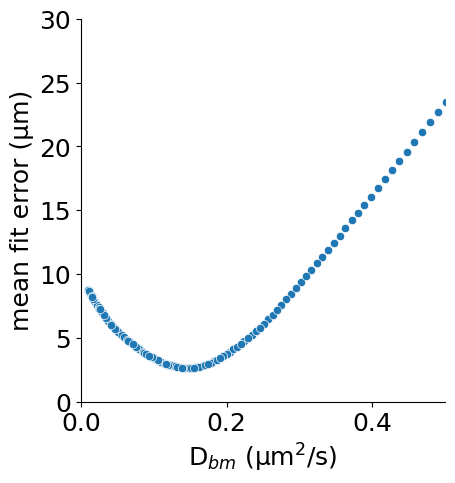

In [113]:
DbmSearchDf=pd.read_csv(os.path.join(dataPath,'simulationData','d_bm_search.csv'))
#dataframe stores average mean fit error across simulations run on a cluster with a fine grid of 201 different Dbm values (between 0.01 and 1um^2/s)
#diff and diff0x store mean fit errors for (1) all experiments and (2) experiments with no antibiotics respectively
rbfDf=DbmSearchDf.copy()
rbfDf['logKprod_bla']=np.log(rbfDf.Kprod_bla)
rbfDf['logKdif']=np.log(rbfDf.Kdif)
rbfDf['logD_bm']=np.log(rbfDf.D_bm)

g=sns.relplot(x='D_bm',y='diff0x',data=rbfDf.reset_index(drop=True))
g.ax.set_ylabel('mean fit error (µm)')
g.ax.set_xlabel('D$_{bm}$ (µm$^2$/s)')
g.ax.set_xlim([0,0.5])
g.ax.set_ylim([0,30])
g.savefig(os.path.join(dataPath,'DbmSearch.pdf'))

rbfFit=Rbf(rbfDf['logD_bm'],rbfDf['diff0x'],function='cubic')
print('Based on experiments without antibiotics, diffusivity of biomass Dbm (microns^2/s) best fits experimental data with value:', np.exp(minimize(lambda xy: rbfFit(*xy),x0=[rbfDf['logD_bm'].mean()]).x))
DbmSearchDf.head()

In [124]:
#create dataframe that simulates random draws of based on actual growth extents, using mean and standard deviation

numDraws=1000
randSimParamsDf=df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].mean().join(df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].std(),lsuffix='_mean',rsuffix='_std')
randSimGreenShiftDf=pd.DataFrame(np.broadcast_to(randSimParamsDf[['GFP shift (μm)_mean']],(len(randSimParamsDf),numDraws))+np.random.randn(len(randSimParamsDf),numDraws)*np.broadcast_to(randSimParamsDf[['GFP shift (μm)_std']],(len(randSimParamsDf),numDraws)))
randSimGreenShiftDf.index=randSimParamsDf.index
randSimGreenShiftDf=randSimGreenShiftDf.reset_index()
randSimGreenShiftDf=randSimGreenShiftDf[randSimGreenShiftDf.expt=='J4K5succ250_ampGrad'].drop('expt',axis=1)
randSimGreenShift0xDf=randSimGreenShiftDf[randSimGreenShiftDf.cond=='0x']
randSimGreenShiftDf=randSimGreenShiftDf.sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])
randSimGreenShift0xDf=randSimGreenShift0xDf.sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])

randSimRedShiftDf=pd.DataFrame(np.broadcast_to(randSimParamsDf[['RFP shift (μm)_mean']],(len(randSimParamsDf),numDraws))+np.random.randn(len(randSimParamsDf),numDraws)*np.broadcast_to(randSimParamsDf[['RFP shift (μm)_std']],(len(randSimParamsDf),numDraws)))
randSimRedShiftDf.index=randSimParamsDf.index
randSimRedShiftDf=randSimRedShiftDf.reset_index()
randSimRedShiftDf=randSimRedShiftDf[randSimRedShiftDf.expt=='J4K5succ250_ampGrad'].drop('expt',axis=1)
randSimRedShift0xDf=randSimRedShiftDf[randSimRedShiftDf.cond=='0x']
randSimRedShiftDf=randSimRedShiftDf.sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])
randSimRedShift0xDf=randSimRedShift0xDf.sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])
randSimRedShift0xDf

C:\Users\Xiaofan\AppData\Local\Temp\ipykernel_12416\333371063.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  randSimParamsDf=df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].mean().join(df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].std(),lsuffix='_mean',rsuffix='_std')
C:\Users\Xiaofan\AppData\Local\Temp\ipykernel_12416\333371063.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  randSimParamsDf=df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].mean().join(df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].std(),lsuffix='_mean',rsuffix='_std')
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.fin

0          1          2          3    \
cond time (h) position (μm)                                               
0x   0        -150            0.000000   0.000000   0.000000   0.000000   
              -100            0.000000   0.000000   0.000000   0.000000   
              -50             0.000000   0.000000   0.000000   0.000000   
               0              0.000000   0.000000   0.000000   0.000000   
               50             0.000000   0.000000   0.000000   0.000000   
...                                ...        ...        ...        ...   
     10        250           31.984323  40.578334  12.412557  26.602271   
               300           35.266705  35.945563  31.883381  32.913758   
               350           23.518190  48.504951  37.281968  58.249895   
               400           36.783968  41.318764  42.713429  40.668953   
               450           41.386636  49.381633  50.039397  52.846804   

                                   4          5          6          7    \
cond time (h) position (μm)                                               
0x   0        -150            0.000000   0.000000   0.000000   0.000000   
              -100            0.000000   0.000000   0.000000   0.000000   
              -50             0.000000   0.000000   0.000000   0.000000   
               0              0.000000   0.000000   0.000000   0.000000   
               50             0.000000   0.000000   0.000000   0.000000   
...                                ...        ...        ...        ...   
     10        250           35.428341  24.484899  41.597823  31.223413   
               300           52.423311  17.845505  38.099029  44.521376   
               350           61.861648  41.713385 -14.386474  46.112780   
               400           40.887348  40.660743  41.105622  40.587578   
               450           37.566751  41.222703  50.835646  39.689275   

                                   8          9    ...        990        991  \
cond time (h) position (μm)                        ...                         
0x   0        -150            0.000000   0.000000  ...   0.000000   0.000000   
              -100            0.000000   0.000000  ...   0.000000   0.000000   
              -50             0.000000   0.000000  ...   0.000000   0.000000   
               0              0.000000   0.000000  ...   0.000000   0.000000   
               50             0.000000   0.000000  ...   0.000000   0.000000   
...                                ...        ...  ...        ...        ...   
     10        250           18.568116  25.768220  ...  28.022233  16.219283   
               300            8.545169  46.796527  ...  51.951789  29.740916   
               350           36.366688  41.835945  ...  54.498076  44.736239   
               400           41.225754  40.044587  ...  39.111335  37.796286   
               450           46.503751  43.144665  ...  42.962378  47.775676   

                                   992        993        994        995  \
cond time (h) position (μm)                                               
0x   0        -150            0.000000   0.000000   0.000000   0.000000   
              -100            0.000000   0.000000   0.000000   0.000000   
              -50             0.000000   0.000000   0.000000   0.000000   
               0              0.000000   0.000000   0.000000   0.000000   
               50             0.000000   0.000000   0.000000   0.000000   
...                                ...        ...        ...        ...   
     10        250            9.052749  26.756093  16.407650  55.329430   
               300           50.215833  27.848256  28.827694  50.664115   
               350           17.009051  37.743596  47.183818   4.710778   
               400           41.132985  42.002508  38.636248  40.171501   
               450           40.430692  47.833152  41.698176  42.131742   

                                   996        997        998      

In [145]:
#load files containing dataframes containing simulated growth extents at different values of Dbm
simParamSearchDfFiles=glob(os.path.join(dataPath,'simulationData','d_bm_search_dfs','*.csv'))

simParamSearchMetaDf=pd.DataFrame([[string for string in re.split('_|=',os.path.basename(simParamSearchDfFile)) if re.match('^[0-9]',string)] for simParamSearchDfFile in simParamSearchDfFiles],
                                 columns=['muMax','Dbm','bmMax','initIllumBmMean','KprodBla','Kdif'])
simParamSearchMetaDf['filename']=simParamSearchDfFiles

#function to compare growth extent in simulation with experimental
def getDiffs(simParamSearchDfFile,simRedShift0xDf=randSimRedShift0xDf,simGreenShift0xDf=randSimGreenShift0xDf,simRedShiftDf=randSimRedShiftDf,simGreenShiftDf=randSimGreenShiftDf):
    simParamSearchDf=pd.read_csv(simParamSearchDfFile,index_col=0)
    simParamSearchDf=simParamSearchDf[simParamSearchDf.expt=='simulation']
    
    gfpShifts=simParamSearchDf.sort_values(by=['cond','rep','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])[['GFP shift (μm)']]
    gfpShifts0x=simParamSearchDf[simParamSearchDf.cond=='0x'].sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])[['GFP shift (μm)']]
    
    rfpShifts=simParamSearchDf.sort_values(by=['cond','rep','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])[['RFP shift (μm)']]
    rfpShifts0x=simParamSearchDf[simParamSearchDf.cond=='0x'].sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])[['RFP shift (μm)']]
    
    diff0x=.5*(pd.DataFrame(np.abs(simRedShift0xDf.values-rfpShifts0x.values)).mean()+pd.DataFrame(np.abs(simGreenShift0xDf.values-gfpShifts0x.values)).mean()).values
    diff=.5*(pd.DataFrame(np.abs(simRedShiftDf.values-rfpShifts.values)).mean()+pd.DataFrame(np.abs(simGreenShiftDf.values-gfpShifts.values)).mean()).values
    return np.concatenate((diff,diff0x))

#for each of 1000 'random drawn' experimental datapoints, find what the best parameter value of Dbm would have been and use to calculate 95% quantile estimate for Dbm
simParamSearchMetaDf[[f'{col}_{suff}' for suff in ['diff','diff0x'] for col in randSimRedShift0xDf.columns]]=[getDiffs(simParamSearchDfFile) for simParamSearchDfFile in simParamSearchDfFiles]
simParamSearchMetaDf=simParamSearchMetaDf.set_index(['muMax','Dbm','bmMax','initIllumBmMean','KprodBla','Kdif','filename'])
simParamSearchMetaDf=simParamSearchMetaDf.reset_index()
simParamRbfMinsDf=pd.DataFrame([(ind,getRbfMin(simParamSearchMetaDf['Dbm'].astype(float),y=simParamSearchMetaDf[f"{ind}_diff0x"].astype(float))[0]) for ind in range(numDraws)],
                              columns=['ind','Dbm'])
print('95% confidence interval of D_bm estimate',np.quantile(simParamRbfMinsDf['Dbm'],[0.025,0.975]))
simParamRbfMinsDf


C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release

95% confidence interval of D_bm estimate [0.13204694 0.16419552]


ind       Dbm
0      0  0.131125
1      1  0.138674
2      2  0.146211
3      3  0.157258
4      4  0.138480
..   ...       ...
995  995  0.159528
996  996  0.153806
997  997  0.146183
998  998  0.149444
999  999  0.142544

[1000 rows x 2 columns]

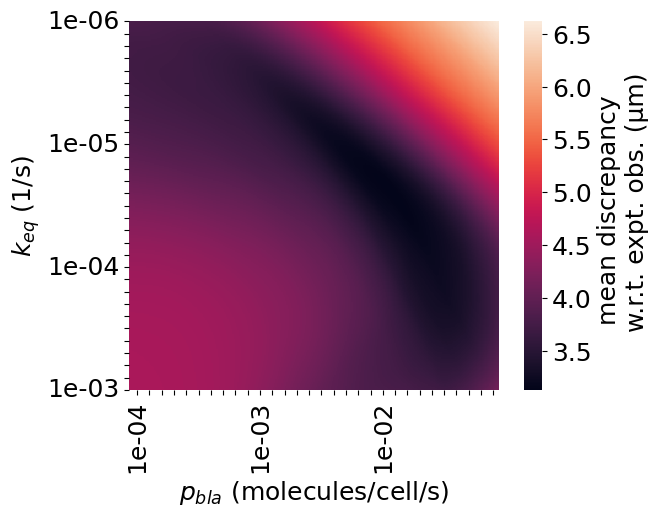

In [196]:
%matplotlib inline
Kprodbla_Kdif_searchHighRes_df=pd.read_csv(os.path.join(dataPath,'simulationData','Kprodbla_Kdif_searchHighRes.csv'))
#translate from Kprodbla which measures beta lactamase production in units of (mg_bla/mL)/(pg_drycellbiomass/um^2)/s to pbla which measures beta lactamase production in molecules(bla)/cell/s
#1 (mg_bla/mL)/(pg_drycellbiomass/um^2)/s is equivalent to [1 (mg_bla/mL)/(pg_drycellbiomass/um^2)/s]x[2e-9mL/um^2]x[0.3pg_drycellbiomass/cell]x[6.02e23molecules(bla)/41584000mg_bla]=8.686e6 molecules(bla)/cell/s
#note [2e-9mL/um^2] comes from the fact that 2mL media are used to fill 6-well plate (with 10cm^2 dimensions), so height of media is 2mm
Kprodbla_Kdif_searchHighRes_df['pbla']=8.686e6*simDiffDfWynton3['Kprod_bla']
Kprodbla_Kdif_searchHighRes_df=Kprodbla_Kdif_searchHighRes_df.sort_values(by=['Kprod_bla','Kdif'])
mat2=Kprodbla_Kdif_searchHighRes_df.groupby(['Kdif','pbla'])['diff'].min().unstack()
fig,ax=plt.subplots()
sns.heatmap(mat2,xticklabels=True,yticklabels=True,cbar_kws={'label': 'mean discrepancy \n w.r.t. expt. obs. (µm)'},ax=ax,square=True)

#fix axes (use plba = 9.973265e-{5,4,3} as locations for 1e-{4,3,2} xticks)
ax.set_xticklabels(["%.0e" % float(label.get_text()) if '973265' in label.get_text() else '' for label in ax.get_xticklabels()])
ax.set_yticklabels(["%.0e" % float(label.get_text()) if ("%.2e" % float(label.get_text())).startswith('1.00e') else '' for label in ax.get_yticklabels()])
ax.set_ylabel('$k_{eq}$ (1/s)')
ax.set_xlabel('$p_{bla}$ (molecules/cell/s)')

ax.get_xticklabels()
# ax.set_xticks([label.get_position()[0] for label in ax.get_xticklabels() if label.get_text() != ''])

xtickposall=[label.get_position()[0] for label in ax.get_xticklabels()]
xtickposlabels=[label.get_position()[0] for label in ax.get_xticklabels() if label.get_text() != '']
xtickposlabelgap=(np.max(xtickposlabels)-np.min(xtickposlabels))/(len(xtickposlabels)-1)
xtickposlabelgap
xtickposnew=[label.get_position()[0] for label in ax.get_xticklabels() if np.mod(label.get_position()[0]-np.max(xtickposlabels),xtickposlabelgap/10)==0]
ax.set_xticks(xtickposnew)

ytickposall=[label.get_position()[1] for label in ax.get_yticklabels()]
ytickposlabels=[label.get_position()[1] for label in ax.get_yticklabels() if label.get_text() != '']
ytickposlabelgap=(np.max(ytickposlabels)-np.min(ytickposlabels))/(len(ytickposlabels)-1)
ytickposlabelgap
ytickposnew=[label.get_position()[1] for label in ax.get_yticklabels() if np.mod(label.get_position()[1]-np.max(ytickposlabels),ytickposlabelgap/10)==0]
ax.set_yticks(ytickposnew)

fig.savefig(os.path.join(savePath,'KprodblaKdifSearchHighRes.pdf'))

In [201]:
#find min values of pbla and keq using RegularGridInterpolator
def getRGImin(xcols,ycol,data):
    df=data.copy()
    for xcol in xcols:
        df[f"log_{xcol}"]=np.log(df[xcol])
    dfmat=df.sort_values(by=[f"log_{xcol}" for xcol in xcols]).set_index([f"log_{xcol}" for xcol in xcols])[ycol].unstack()
    interp=RegularGridInterpolator((np.asarray(dfmat.index),np.asarray(dfmat.columns)),dfmat.values,method='cubic', bounds_error=False,fill_value=None)
    try:
        return np.exp(minimize(lambda x: interp(x),x0=df[[f"log_{xcol}" for xcol in xcols]].mean()).x)
    except:
        return np.full(len(xcols), np.nan)
minvals=getRGImin(xcols=['Kprod_bla','Kdif'],ycol='diff',data=Kprodbla_Kdif_searchHighRes_df)
print('optimized fit values for pbla,k_eq:',minvals[0]*8.686e6,minvals[1])#use conversion factor (see above cell) from Kprod_bla to pbla

optimized fit values for pbla,k_eq: 0.013332511512727838 2.8558595972019876e-05


In [209]:
#create dataframe that simulates random draws of based on actual growth extents, using mean and standard deviation

numDraws=1000
randSimParamsDf=df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].mean().join(df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].std(),lsuffix='_mean',rsuffix='_std')
randSimGreenShiftDf=pd.DataFrame(np.broadcast_to(randSimParamsDf[['GFP shift (μm)_mean']],(len(randSimParamsDf),numDraws))+np.random.randn(len(randSimParamsDf),numDraws)*np.broadcast_to(randSimParamsDf[['GFP shift (μm)_std']],(len(randSimParamsDf),numDraws)))
randSimGreenShiftDf.index=randSimParamsDf.index
randSimGreenShiftDf=randSimGreenShiftDf.reset_index()
randSimGreenShiftDf=randSimGreenShiftDf[randSimGreenShiftDf.expt=='J4K5succ250_ampGrad'].drop('expt',axis=1)
randSimGreenShift0xDf=randSimGreenShiftDf[randSimGreenShiftDf.cond=='0x']
randSimGreenShiftDf=randSimGreenShiftDf.sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])
randSimGreenShift0xDf=randSimGreenShift0xDf.sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])

randSimRedShiftDf=pd.DataFrame(np.broadcast_to(randSimParamsDf[['RFP shift (μm)_mean']],(len(randSimParamsDf),numDraws))+np.random.randn(len(randSimParamsDf),numDraws)*np.broadcast_to(randSimParamsDf[['RFP shift (μm)_std']],(len(randSimParamsDf),numDraws)))
randSimRedShiftDf.index=randSimParamsDf.index
randSimRedShiftDf=randSimRedShiftDf.reset_index()
randSimRedShiftDf=randSimRedShiftDf[randSimRedShiftDf.expt=='J4K5succ250_ampGrad'].drop('expt',axis=1)
randSimRedShift0xDf=randSimRedShiftDf[randSimRedShiftDf.cond=='0x']
randSimRedShiftDf=randSimRedShiftDf.sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])
randSimRedShift0xDf=randSimRedShift0xDf.sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])
randSimRedShift0xDf

C:\Users\Xiaofan\AppData\Local\Temp\ipykernel_12416\2109110597.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  randSimParamsDf=df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].mean().join(df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].std(),lsuffix='_mean',rsuffix='_std')
C:\Users\Xiaofan\AppData\Local\Temp\ipykernel_12416\2109110597.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  randSimParamsDf=df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].mean().join(df.groupby(['expt','cond','time (h)','position (μm)'])['GFP shift (μm)','RFP shift (μm)'].std(),lsuffix='_mean',rsuffix='_std')
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.f

0          1          2          3    \
cond time (h) position (μm)                                               
0x   0        -150            0.000000   0.000000   0.000000   0.000000   
              -100            0.000000   0.000000   0.000000   0.000000   
              -50             0.000000   0.000000   0.000000   0.000000   
               0              0.000000   0.000000   0.000000   0.000000   
               50             0.000000   0.000000   0.000000   0.000000   
...                                ...        ...        ...        ...   
     10        250           39.779713  40.490257  34.166050  34.606126   
               300           47.089958  42.143357  37.790171  50.426368   
               350           48.365015  22.396593  34.507988  13.153225   
               400           41.942805  41.768301  40.849538  41.806717   
               450           46.229101  41.873952  39.259204  47.826835   

                                   4          5          6          7    \
cond time (h) position (μm)                                               
0x   0        -150            0.000000   0.000000   0.000000   0.000000   
              -100            0.000000   0.000000   0.000000   0.000000   
              -50             0.000000   0.000000   0.000000   0.000000   
               0              0.000000   0.000000   0.000000   0.000000   
               50             0.000000   0.000000   0.000000   0.000000   
...                                ...        ...        ...        ...   
     10        250           21.600428  19.524943  28.956792  21.714156   
               300           42.079910  24.458373  15.369760  30.348707   
               350           62.683634  24.682135  49.179061  24.327271   
               400           40.853776  41.285304  42.514584  38.658146   
               450           46.178263  45.454171  43.760174  44.135609   

                                   8          9    ...        990        991  \
cond time (h) position (μm)                        ...                         
0x   0        -150            0.000000   0.000000  ...   0.000000   0.000000   
              -100            0.000000   0.000000  ...   0.000000   0.000000   
              -50             0.000000   0.000000  ...   0.000000   0.000000   
               0              0.000000   0.000000  ...   0.000000   0.000000   
               50             0.000000   0.000000  ...   0.000000   0.000000   
...                                ...        ...  ...        ...        ...   
     10        250           31.779637  21.312198  ...  37.223034  38.511663   
               300           33.741404  32.959564  ...  36.240008  15.203923   
               350           33.294261  59.681917  ...   4.051432  75.586211   
               400           40.892586  40.156019  ...  41.694370  41.503127   
               450           46.697442  40.334033  ...  40.125613  42.935520   

                                   992        993        994        995  \
cond time (h) position (μm)                                               
0x   0        -150            0.000000   0.000000   0.000000   0.000000   
              -100            0.000000   0.000000   0.000000   0.000000   
              -50             0.000000   0.000000   0.000000   0.000000   
               0              0.000000   0.000000   0.000000   0.000000   
               50             0.000000   0.000000   0.000000   0.000000   
...                                ...        ...        ...        ...   
     10        250           20.763789  34.573545  47.949793  41.033744   
               300           25.847263  22.272449  36.037173  29.498358   
               350           50.761460  57.888244  28.088967  47.668912   
               400           39.446127  39.770378  41.552394  42.820770   
               450           43.025656  43.701746  42.141257  47.948507   

                                   996        997        998      

In [212]:
#parameter fitting search for k_eq and pbla
simParamSearchDfFiles=glob(os.path.join(dataPath,'simulationData','Kprodbla_Kdif_search','*.csv'))

simParamSearchMetaDf=pd.DataFrame([[string for string in re.split('_|=',os.path.basename(simParamSearchDfFile)) if re.match('^[0-9]',string)] for simParamSearchDfFile in simParamSearchDfFiles],
                                 columns=['muMax','Dbm','bmMax','initIllumBmMean','KprodBla','Kdif'])

simParamSearchMetaDf['filename']=simParamSearchDfFiles

def getDiffs(simParamSearchDfFile,simRedShift0xDf=randSimRedShift0xDf,simGreenShift0xDf=randSimGreenShift0xDf,simRedShiftDf=randSimRedShiftDf,simGreenShiftDf=randSimGreenShiftDf):
    simParamSearchDf=pd.read_csv(simParamSearchDfFile,index_col=0)
    simParamSearchDf=simParamSearchDf[simParamSearchDf.expt=='simulation']
    
    gfpShifts=simParamSearchDf.sort_values(by=['cond','rep','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])[['GFP shift (μm)']]
    gfpShifts0x=simParamSearchDf[simParamSearchDf.cond=='0x'].sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])[['GFP shift (μm)']]
    
    rfpShifts=simParamSearchDf.sort_values(by=['cond','rep','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])[['RFP shift (μm)']]
    rfpShifts0x=simParamSearchDf[simParamSearchDf.cond=='0x'].sort_values(by=['cond','time (h)','position (μm)']).set_index(['cond','time (h)','position (μm)'])[['RFP shift (μm)']]
    
    diff0x=.5*(pd.DataFrame(np.abs(simRedShift0xDf.values-rfpShifts0x.values)).mean()+pd.DataFrame(np.abs(simGreenShift0xDf.values-gfpShifts0x.values)).mean()).values
    diff=.5*(pd.DataFrame(np.abs(simRedShiftDf.values-rfpShifts.values)).mean()+pd.DataFrame(np.abs(simGreenShiftDf.values-gfpShifts.values)).mean()).values
    return np.concatenate((diff,diff0x))


simParamSearchMetaDf[[f'{col}_{suff}' for suff in ['diff','diff0x'] for col in randSimRedShift0xDf.columns]]=[getDiffs(simParamSearchDfFile) for simParamSearchDfFile in simParamSearchDfFiles]

simParamRbfMinsDf=pd.DataFrame([getRGImin(xcols=['Kdif','KprodBla'],ycol=f"{ind}_diff",data=simParamSearchMetaDf[['Kdif','KprodBla',f"{ind}_diff"]].astype(float)) for ind in range(numDraws)],
                              columns=['Kdif','KprodBla'])


print('95% confidence interval of k_eq estimate',np.quantile(simParamRbfMinsDf['Kdif'],[0.025,0.975]))
print('95% confidence interval of pbla estimate',8.686e6*np.quantile(simParamRbfMinsDf['KprodBla'],[0.025,0.975]))


C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release

95% confidence interval of k_eq estimate [1.72476566e-05 3.12013019e-05]
95% confidence interval of pbla estimate [0.00767028 0.01397039]


In [406]:
#standalone analysis
def fitX0Standalone(y,x=None,bounds=None):
    if x is None:
        x=range(len(y))
    if bounds is None:
        bounds=([0,0,0,min(x)],[np.max(y),max(x)-min(x),np.max(y),max(x)])
    params,_=curve_fit(f=logisticFunc,
          xdata=x,ydata=y,
          method='trf',bounds=bounds,loss='soft_l1',max_nfev=1e8)
    return params

def fitSliceStandalone(imgZsum,lim1,lim2,frame,channel,xlims=None,umPerPixel=850/256):
    imgSlice=imgZsum[frame,:,lim1:lim2,channel].T
    if xlims is None:
        xlims=[0,imgSlice.shape[1]]
    xlims[0]=np.max([0,xlims[0]])
    xlims[1]=np.min([imgSlice.shape[1],xlims[1]])
    y=np.sum(imgSlice[:,xlims[0]:xlims[1]],axis=0)
    x=umPerPixel*np.arange(*xlims)
    x=x[y>0]
    y=y[y>0]
    ymin=np.min(y)
    ymax=np.max(y)
    params=fitX0(x=x,y=y)
    return params


expts=[expt for expt in tiffDf.expt.unique() if 'standalone' in expt]
# expts=[expt for expt in tiffDf.expt.unique() if 'standalone' in expt and 'ampGrad' in expt]

reps=[1,2,3]
conds=['0x','1x','3x','10x','30x','100x']


numFrames=6
umPerPixel=850/256

slicePosInPixels=[116,140] #take the middle 80um slice for each image
halfSliceLengthInPixels=256

tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds),:]
standaloneDf=pd.DataFrame([])
for row in tiffDfSubset.iterrows():
    img=readTiff(row[1].filename)
    expt=row[1].expt
    cond=row[1].cond
    rep=row[1].rep
    imgZsum=np.mean(img,axis=1)

    if '250' in expt:
        channel=1 #gfp
    else:
        channel=0 #rfp
    print(expt,cond,rep)

    newDf=pd.DataFrame({'expt':expt,
                        'cond':cond,
                        'rep':rep,
                        'time (h)':2*np.arange(numFrames),
                        'pixelRange':f"{slicePosInPixels[0]}-{slicePosInPixels[1]}",
                        'X0':[fitSliceStandalone(imgZsum,slicePosInPixels[0],slicePosInPixels[1],frameNum,channel=channel)[-1] for frameNum in range(numFrames)]
                       })
    newDf['shift (μm)']=newDf.X0-newDf.loc[newDf['time (h)']==0,'X0'].values[0]
    standaloneDf=pd.concat([standaloneDf,newDf])


standaloneDf=standaloneDf.reset_index(drop=True)
standaloneDf['redPixelRange']=[pixelRange if 'J4K5' in expt else '' for pixelRange,expt in zip(standaloneDf.pixelRange,standaloneDf.expt)]
standaloneDf['greenPixelRange']=[pixelRange if 'J4K5' not in expt else '' for pixelRange,expt in zip(standaloneDf.pixelRange,standaloneDf.expt)]
standaloneDf['redX0']=[X0 if 'J4K5' in expt else np.nan for X0,expt in zip(standaloneDf.X0,standaloneDf.expt)]
standaloneDf['greenX0']=[X0 if 'J4K5' not in expt else np.nan for X0,expt in zip(standaloneDf.X0,standaloneDf.expt)]
standaloneDf['RFP shift (μm)']=[shift if 'J4K5' in expt else np.nan for shift,expt in zip(standaloneDf['shift (μm)'],standaloneDf.expt)]
standaloneDf['GFP shift (μm)']=[shift if 'J4K5' not in expt else np.nan for shift,expt in zip(standaloneDf['shift (μm)'],standaloneDf.expt)]

ampCondDict=dict(zip([f"{intCond}x" for intCond in np.sort([int(cond.strip('x')) for cond in standaloneDf.cond.unique()])],
                     [0]+list(np.power(10,np.arange(-1,1.5,.5)))))
kanCondDict=dict(zip([f"{intCond}x" for intCond in np.sort([int(cond.strip('x')) for cond in standaloneDf.cond.unique()])],
                     [0]+list(0.5*np.power(10,np.arange(-1,1.5,.5)))))
standaloneDf['[Ampicillin] (mg/mL)']=standaloneDf.cond.map(ampCondDict)
standaloneDf['[Kanamycin] (mg/mL)']=standaloneDf.cond.map(kanCondDict)
standaloneDf.loc[standaloneDf.expt.str.contains('kanGrad'),'[Ampicillin] (mg/mL)']=np.nan
standaloneDf.loc[standaloneDf.expt.str.contains('ampGrad'),'[Kanamycin] (mg/mL)']=np.nan

standaloneDf['position (μm)']=np.nan
standaloneDf.to_csv(os.path.join(savePath,'standaloneDf.csv',index=False)

standaloneDf.head()

250standalone_ampGrad 0x 1
250standalone_ampGrad 0x 2
250standalone_ampGrad 0x 3
250standalone_ampGrad 1x 1
250standalone_ampGrad 1x 2
250standalone_ampGrad 1x 3
250standalone_ampGrad 3x 1
250standalone_ampGrad 3x 2
250standalone_ampGrad 3x 3
250standalone_ampGrad 10x 1
250standalone_ampGrad 10x 2
250standalone_ampGrad 10x 3
250standalone_ampGrad 30x 1
250standalone_ampGrad 30x 2
250standalone_ampGrad 30x 3
250standalone_ampGrad 100x 1
250standalone_ampGrad 100x 2
250standalone_ampGrad 100x 3
250standalone_kanGrad 0x 1
250standalone_kanGrad 0x 2
250standalone_kanGrad 0x 3
250standalone_kanGrad 1x 1
250standalone_kanGrad 1x 2
250standalone_kanGrad 1x 3
250standalone_kanGrad 3x 1
250standalone_kanGrad 3x 2
250standalone_kanGrad 3x 3
250standalone_kanGrad 10x 1
250standalone_kanGrad 10x 2
250standalone_kanGrad 10x 3
250standalone_kanGrad 30x 1
250standalone_kanGrad 30x 2
250standalone_kanGrad 30x 3
250standalone_kanGrad 100x 1
250standalone_kanGrad 100x 2
250standalone_kanGrad 100x 3
J4K5

C:\Users\Xiaofan\AppData\Local\Temp\ipykernel_13464\117087721.py:33: RuntimeWarning: overflow encountered in exp
  return a/(1+np.exp((x-x0)/b))+c


J4K5standalone_kanGrad 30x 1
J4K5standalone_kanGrad 30x 2
J4K5standalone_kanGrad 30x 3
J4K5standalone_kanGrad 100x 1
J4K5standalone_kanGrad 100x 2
J4K5standalone_kanGrad 100x 3


expt cond  rep  time (h) pixelRange          X0  \
0  250standalone_ampGrad   0x    1         0    116-140  307.329122   
1  250standalone_ampGrad   0x    1         2    116-140  326.448107   
2  250standalone_ampGrad   0x    1         4    116-140  379.081050   
3  250standalone_ampGrad   0x    1         6    116-140  441.215215   
4  250standalone_ampGrad   0x    1         8    116-140  538.635006   

   shift (μm) redPixelRange greenPixelRange  redX0     greenX0  \
0    0.000000                       116-140    NaN  307.329122   
1   19.118984                       116-140    NaN  326.448107   
2   71.751928                       116-140    NaN  379.081050   
3  133.886093                       116-140    NaN  441.215215   
4  231.305884                       116-140    NaN  538.635006   

   RFP shift (μm)  GFP shift (μm)  [Ampicillin] (mg/mL)  [Kanamycin] (mg/mL)  \
0             NaN        0.000000                   0.0                  NaN   
1             NaN       19.118984                   0.0                  NaN   
2             NaN       71.751928                   0.0                  NaN   
3             NaN      133.886093                   0.0                  NaN   
4             NaN      231.305884                   0.0                  NaN   

   position (μm)  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [434]:
for condConcentration in [('0x','0mg/mL'),('1x','0.1mg/mL'),('10x','1mg/mL'),('30x','3mg/mL'),('100x','10mg/mL')]:
    print('\n')
    compDf=standaloneDf[(standaloneDf.expt=='J4K5standalone_ampGrad')&(standaloneDf.cond==condConcentration[0])&(standaloneDf['time (h)']>0)&(standaloneDf['time (h)']<10)]
    compDf.columns=[col.split()[0] for col in compDf.columns]
    
    
    print(f'RFP growth rate test for standalone culture, ampicillin concentration {condConcentration[1]}')
    mod = smf.ols(formula='RFP  ~ time', data=compDf)
    
    res = mod.fit()
    printRes(res)


    compDf=standaloneDf[(standaloneDf.expt=='250standalone_ampGrad')&(standaloneDf.cond==condConcentration[0])&(standaloneDf['time (h)']>0)&(standaloneDf['time (h)']<10)]
    compDf.columns=[col.split()[0] for col in compDf.columns]

    print(f'GFP growth rate test for standalone culture, ampicillin concentration {condConcentration[1]}')
    mod = smf.ols(formula='GFP  ~ time', data=compDf)
    
    res = mod.fit()
    
    printRes(res)



RFP growth rate test for standalone culture, ampicillin concentration 0mg/mL
var=time, coeffs=8.4±0.6, pval=1.0836621741486071e-07
GFP growth rate test for standalone culture, ampicillin concentration 0mg/mL
var=time, coeffs=33.1±1.4, pval=3.202064577779816e-10


RFP growth rate test for standalone culture, ampicillin concentration 0.1mg/mL
var=time, coeffs=-0.6±0.2, pval=0.02262790971627462
GFP growth rate test for standalone culture, ampicillin concentration 0.1mg/mL
var=time, coeffs=33.2±1.6, pval=1.6852855637401231e-09


RFP growth rate test for standalone culture, ampicillin concentration 1mg/mL
var=time, coeffs=0.2±0.3, pval=0.4430299462895648
GFP growth rate test for standalone culture, ampicillin concentration 1mg/mL
var=time, coeffs=40.9±2.0, pval=1.7996417250054238e-09


RFP growth rate test for standalone culture, ampicillin concentration 3mg/mL
var=time, coeffs=-1.4±0.6, pval=0.03927139684407496
GFP growth rate test for standalone culture, ampicillin concentration 3mg/mL


In [428]:
for condConcentration in [('0x','0mg/mL'),('1x','0.1mg/mL'),('10x','1mg/mL'),('30x','3mg/mL'),('100x','10mg/mL')]:
    print('\n')
    position=400
    compDf=df[(df.expt=='J4K5succ250_ampGrad')&(df.cond==condConcentration[0])&(df['position (μm)']==position)&(df['time (h)']<10)]
    compDf.columns=[col.split()[0] for col in compDf.columns]
    
    
    print(f'RFP growth rate test at position {position} microns, ampicillin concentration {condConcentration[1]}')
    mod = smf.ols(formula='RFP  ~ time', data=compDf)
    
    res = mod.fit()
    printRes(res)

    print(f'GFP growth rate test at position {position} microns, ampicillin concentration {condConcentration[1]}')
    mod = smf.ols(formula='GFP  ~ time', data=compDf)
    
    res = mod.fit()
    
    printRes(res)



RFP growth rate test at position 400 microns, ampicillin concentration 0mg/mL
var=time, coeffs=4.2±0.5, pval=2.1006298762047603e-06
GFP growth rate test at position 400 microns, ampicillin concentration 0mg/mL
var=time, coeffs=5.0±0.3, pval=1.069394523277413e-09


RFP growth rate test at position 400 microns, ampicillin concentration 0.1mg/mL
var=time, coeffs=2.3±0.4, pval=1.9214623243241584e-05
GFP growth rate test at position 400 microns, ampicillin concentration 0.1mg/mL
var=time, coeffs=5.0±0.6, pval=3.2106416555218725e-06


RFP growth rate test at position 400 microns, ampicillin concentration 1mg/mL
var=time, coeffs=0.2±0.4, pval=0.5947179944264349
GFP growth rate test at position 400 microns, ampicillin concentration 1mg/mL
var=time, coeffs=4.2±0.3, pval=6.098249266114915e-10


RFP growth rate test at position 400 microns, ampicillin concentration 3mg/mL
var=time, coeffs=-0.4±0.4, pval=0.40565369314406063
GFP growth rate test at position 400 microns, ampicillin concentration 3

In [444]:
compDf=pd.concat([df[(df.expt=='J4K5succ250_ampGrad')&(df.cond=='0x')&(df['time (h)']>0)&(df['time (h)']<10)&(df['position (μm)'].isin([400]))],
           standaloneDf[(standaloneDf.expt=='J4K5standalone_ampGrad')&(standaloneDf.cond=='0x')&(standaloneDf['time (h)']>0)&(standaloneDf['time (h)']<10)]
          ])
compDf.columns=[col.split()[0] for col in compDf.columns]
compDf['monoculture']=[True if 'standalone' in expt else False for expt in compDf.expt]

md = smf.mixedlm("RFP ~ monoculture", compDf, groups=compDf["time"])
print('LMM to test RFP growth is faster in monoculture biofilm than co-culture biofilm, with no antibiotics')

mdf = md.fit()
printRes(mdf,var="monoculture[T.True]")

compDf=pd.concat([df[(df.expt=='J4K5succ250_ampGrad')&(df.cond=='0x')&(df['time (h)']>0)&(df['time (h)']<10)&(df['position (μm)'].isin([400]))],
           standaloneDf[(standaloneDf.expt=='250standalone_ampGrad')&(standaloneDf.cond=='0x')&(standaloneDf['time (h)']>0)&(standaloneDf['time (h)']<10)]
          ])
compDf.columns=[col.split()[0] for col in compDf.columns]
compDf['monoculture']=[True if 'standalone' in expt else False for expt in compDf.expt]

md = smf.mixedlm("GFP ~ monoculture", compDf, groups=compDf["time"])
print('LMM to test GFP growth is faster in monoculture biofilm than co-culture biofilm, with no antibiotics')

mdf = md.fit()
printRes(mdf,var="monoculture[T.True]")


compDf=pd.concat([df[(df.expt=='J4K5succ250_ampGrad')&(df.cond=='1x')&(df['time (h)']>0)&(df['time (h)']<10)&(df['position (μm)'].isin([400]))],
           standaloneDf[(standaloneDf.expt=='J4K5standalone_ampGrad')&(standaloneDf.cond=='1x')&(standaloneDf['time (h)']>0)&(standaloneDf['time (h)']<10)]
          ])
compDf.columns=[col.split()[0] for col in compDf.columns]
compDf['monoculture']=[True if 'standalone' in expt else False for expt in compDf.expt]

md = smf.mixedlm("RFP ~ monoculture", compDf, groups=compDf["time"])
print('LMM to test RFP growth is faster in co-culture biofilm than monoculture biofilm, with 0.1mg/mL ampicillin')

mdf = md.fit()
printRes(mdf,var="monoculture[T.True]")

LMM to test RFP growth is faster in monoculture biofilm than co-culture biofilm, with no antibiotics
var=monoculture[T.True], coeffs=9.5±2.8, pval=0.0006104416739339516
LMM to test GFP growth is faster in monoculture biofilm than co-culture biofilm, with no antibiotics
var=monoculture[T.True], coeffs=89.2±14.6, pval=9.68774466832598e-10
LMM to test RFP growth is faster in co-culture biofilm than monoculture biofilm, with 0.1mg/mL ampicillin
var=monoculture[T.True], coeffs=-10.7±2.1, pval=2.8385810512522896e-07


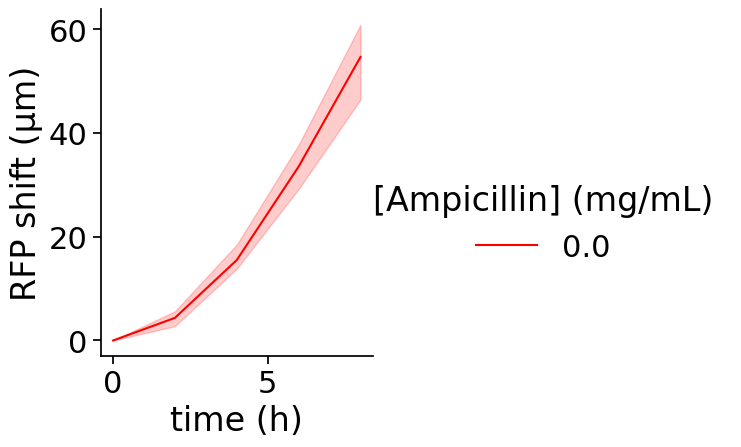

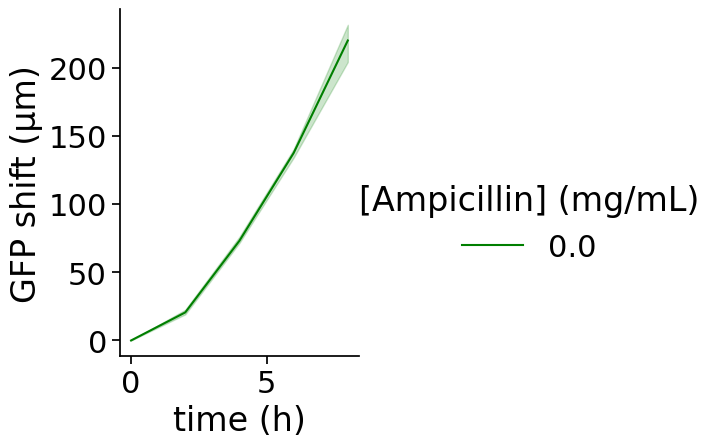

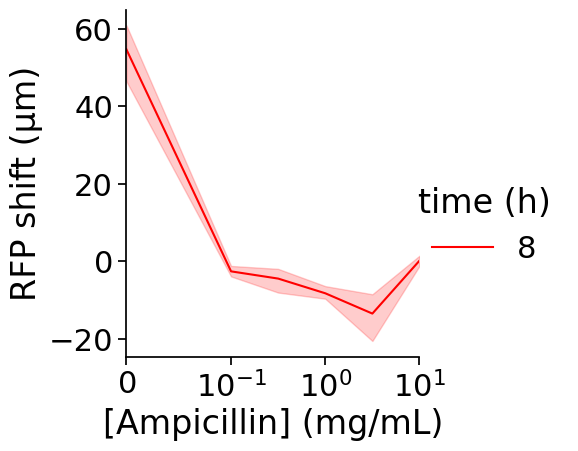

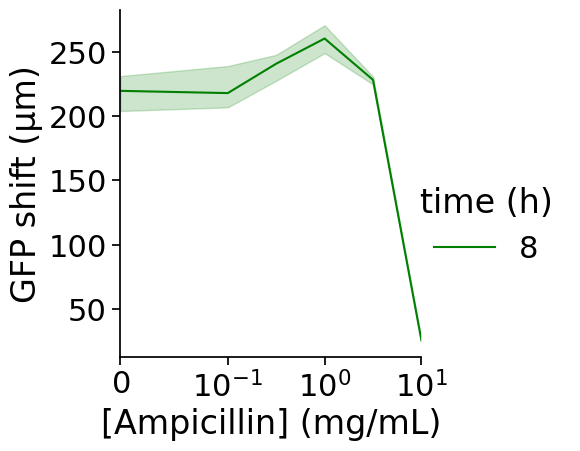

In [65]:
standalonePlotDf=standaloneDf[(standaloneDf['[Ampicillin] (mg/mL)']==0)&(standaloneDf['time (h)']<10)]
with sns.plotting_context("notebook",font_scale=2):

    sns.relplot(kind='line',x='time (h)',hue='[Ampicillin] (mg/mL)',y='RFP shift (μm)',data=standalonePlotDf,palette=["#FF0000"])
    sns.relplot(kind='line',x='time (h)',hue='[Ampicillin] (mg/mL)',y='GFP shift (μm)',data=standalonePlotDf,palette=["#007F00"])

standalonePlotDf=standaloneDf[(standaloneDf['time (h)']==8)]
with sns.plotting_context("notebook",font_scale=2):

    sns.relplot(kind='line',hue='time (h)',x='[Ampicillin] (mg/mL)',y='RFP shift (μm)',data=standalonePlotDf,palette=["#FF0000"])
    plt.xscale('symlog', linthresh=0.1)
    plt.xlim([0,10])
    sns.relplot(kind='line',hue='time (h)',x='[Ampicillin] (mg/mL)',y='GFP shift (μm)',data=standalonePlotDf,palette=["#007F00"])
    plt.xscale('symlog', linthresh=0.1)
    plt.xlim([0,10])


C:\Users\Xiaofan\AppData\Local\Temp\ipykernel_15180\2028635064.py:13: RuntimeWarning: invalid value encountered in divide
  return plt.imshow((img-vmin)/(vmax-vmin),**kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


C:\Users\Xiaofan/Desktop\confocal data\timelapseProcessed\250standalone_ampGrad_withReplicates_tif\shifted\250standalone_ampGrad_withReplicates_shifted_p03.tif
(18, 61, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


C:\Users\Xiaofan/Desktop\confocal data\timelapseProcessed\J4K5standalone_ampGrad37_withReplicates_tiff\shifted\J4K5standalone_ampGrad37_withReplicates_shifted_p03.tif
(18, 46, 256, 256, 3)


Text(0, 0.5, 'vertical axis (μm)')

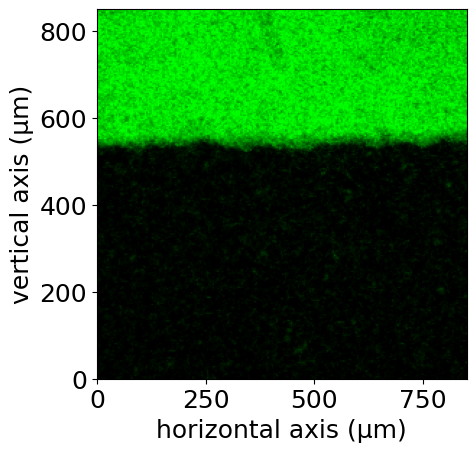

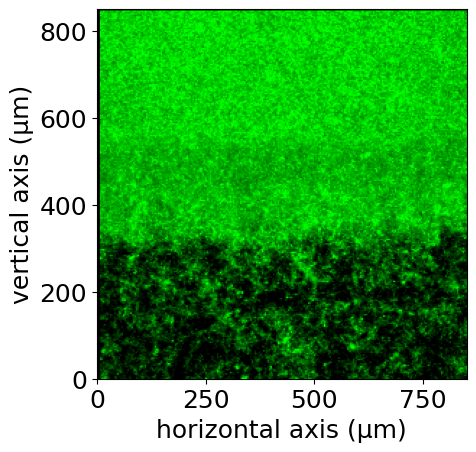

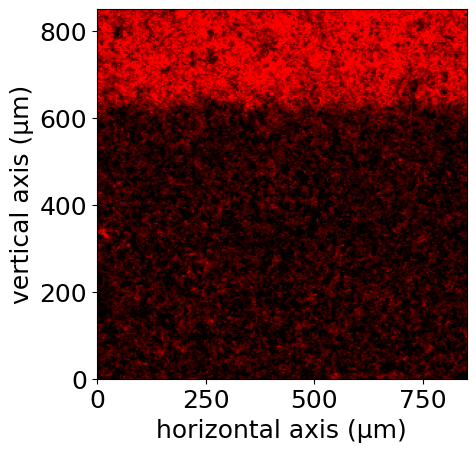

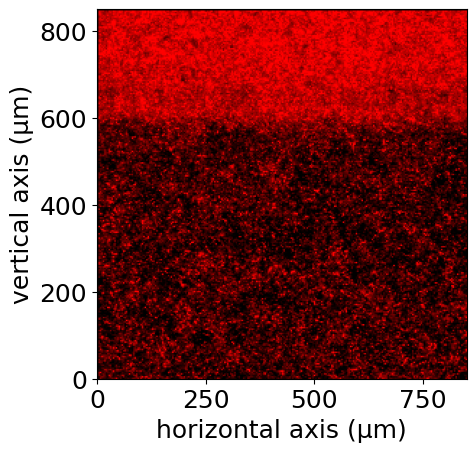

In [131]:
expts=['250standalone_ampGrad']
reps=[1]
conds=['0x']
tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds)&tiffDf.cond.isin(conds),:]
img=readTiff(tiffDfSubset.filename.values[0])
print(tiffDfSubset.filename.values[0])
print(img.shape)
img[:,:,:,:,[0,2]]=0
plt.figure()
imagesc(np.mean(img[0,:,:,:,:],axis=0),extent=[0,850,0,850])
plt.xlabel('horizontal axis (μm)')
plt.ylabel('vertical axis (μm)')
plt.figure()
imagesc(np.mean(img[4,:,:,:,:],axis=0),extent=[0,850,0,850])
plt.xlabel('horizontal axis (μm)')
plt.ylabel('vertical axis (μm)')

expts=['J4K5standalone_ampGrad']
reps=[1]
conds=['0x']
tiffDfSubset=tiffDf.loc[tiffDf.expt.isin(expts)&tiffDf.rep.isin(reps)&tiffDf.cond.isin(conds)&tiffDf.cond.isin(conds),:]
img=readTiff(tiffDfSubset.filename.values[0])
print(tiffDfSubset.filename.values[0])
print(img.shape)
img[:,:,:,:,[1,2]]=0
plt.figure()
imagesc(np.mean(img[0,:,:,:,:],axis=0),extent=[0,850,0,850])
plt.xlabel('horizontal axis (μm)')
plt.ylabel('vertical axis (μm)')
plt.figure()
imagesc(np.mean(img[4,:,:,:,:],axis=0),extent=[0,850,0,850])
plt.xlabel('horizontal axis (μm)')
plt.ylabel('vertical axis (μm)')


In [289]:
def fitSimSlice(img,lim1,lim2,channel,xlims=None,umPerPixel=850/64):
    if channel==1:
        imgSlice=img[lim1:lim2,:]
    elif channel==0:
        imgSlice=img[:,lim1:lim2].T
    else:
        return None
    if xlims is None:
        xlims=[0,imgSlice.shape[1]]
    y=np.sum(imgSlice[:,xlims[0]:xlims[1]],axis=0)
    x=umPerPixel*np.arange(*xlims)
    x=x[y>0]
    y=y[y>0]
    ymin=np.min(y)
    ymax=np.max(y)
    params=fitX0(x=x,y=y)
    return params
def minZero(mat):
    mat[mat<0]=0
    return mat
class biofilmKanSimulate:
    def __init__(self,
                exptName="simulation",
                xSize=64,
                dt=6,
                simTimeInSeconds=36000,
                simSizeInMicrons=850,
                initKan=0.5,#initial ampicillin concentration in mg/mL
                initNutr=2,#initial nutrients in mg/mL
                bmMax=6,#carrying capacity of biomass density, in pg/um^2 (dry biomass, 1 cell~0.3pg)
                initDarkBmMean=None,#how much biomass density to initialize unilluminated regions in pg/um^2 (dry biomass, 1 cell~0.3pg)
                initIllumBmMean=3,#how much biomass to initialize illuminated regions in pg/um^2 (dry biomass, 1 cell~0.3pg)
                fractionIllum=0.25,#what fraction of simulation area is illuminated for each strain

                gammaBm=5.6e-6,#death rate of biomass in s^-1
                gammaKan=0,#inherent decay rate of kanamycin in s^-1 

                D_nutr=600,#diffusivity of nutrients in um^2/s
                D_bm=0.149,#diffusivity of biomass in um^2/s
                D_kan=400,#diffusivity of kanamycin in um^2/s
                 
                muMax=4.8e-5, #max growth rate in s^-1
                 
                K_nutr=0.004,#nutrient concentration at half max growth rate in mg/mL glucose
                yield_nutr=0.632,#nutrient to biomass conversion yield in (pg/um^2 biomass density)/(mg/mL nutrient)
                K_kanR=0.512,#hill constant for ampicillin inhibition of red cells
                K_kanG=0.002,#hill constant for ampicillin inhibition of green cells
                h_kan=1.9,#hill coefficient for aminoglyocoside inhibition of red and green cells (using streptomycin value from regoes 2004)
                Kdif=2.7e-5,#rate constant of diffusion of kanamycin into biofilm, in s^-1

                ):
        if initDarkBmMean is None:
            initDarkBmMean=initIllumBmMean/100
        warnings.filterwarnings('ignore')
        self.params=locals()
        self.params.pop('self')
        self.params['nSteps']=int(simTimeInSeconds/dt)
        self.params['cond']=f"{int(float('%.1g' % (initKan*20)))}x"
        self.params['dx']=simSizeInMicrons/xSize
        self.Dmat=-2*np.diag(np.ones(xSize))+np.diag(np.ones(xSize-1),1)+np.diag(np.ones(xSize-1),-1)
        self.Dmat[0,0]=-1
        self.Dmat[-1,-1]=-1
        initBm1d=initDarkBmMean+(initIllumBmMean-initDarkBmMean)*np.exp(-(np.arange(xSize)-xSize*fractionIllum))/(1+np.exp(-(np.arange(xSize)-xSize*fractionIllum)))

        self.Gbm=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.Gbm[:,:,0]=np.tile(initBm1d,(xSize,1))
        self.Rbm=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.Rbm[:,:,0]=np.tile(initBm1d,(xSize,1)).T
        self.mu_R=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.mu_G=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.kanMedia=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.kanMedia[:,:,0]=initKan
        self.kanBiofilm=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.bla=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32) 
        self.nutr=np.zeros([self.params['xSize'],
                           self.params['xSize'],
                           self.params['nSteps']+1],
                         dtype=np.float32)
        self.nutr[:,:,0]=initNutr
        self.greenCmap=LinearSegmentedColormap.from_list("greenCmap",[[0,0,0],[0,1,0]])
        self.redCmap=LinearSegmentedColormap.from_list("redCmap",[[0,0,0],[1,0,0]])
        warnings.filterwarnings('default')
        
    def simulate(self,nSteps=None):
        warnings.filterwarnings('ignore')
        if nSteps is None:
            nSteps=self.params['nSteps']
        for step in np.arange(nSteps):
            self.mu_R[:,:,step]=self.params['muMax']*np.divide(self.nutr[:,:,step],(self.nutr[:,:,step]+self.params['K_nutr']))*(1-(self.Rbm[:,:,step]+self.Gbm[:,:,step])/self.params['bmMax'])*np.divide(np.power(self.params['K_kanR'],self.params['h_kan']),(np.power(self.kanBiofilm[:,:,step],self.params['h_kan'])+np.power(self.params['K_kanR'],self.params['h_kan'])))
            self.mu_G[:,:,step]=self.params['muMax']*np.divide(self.nutr[:,:,step],(self.nutr[:,:,step]+self.params['K_nutr']))*(1-(self.Rbm[:,:,step]+self.Gbm[:,:,step])/self.params['bmMax'])*np.divide(np.power(self.params['K_kanG'],self.params['h_kan']),(np.power(self.kanBiofilm[:,:,step],self.params['h_kan'])+np.power(self.params['K_kanG'],self.params['h_kan'])))
            self.Rbm[:,:,step+1]=self.Rbm[:,:,step]*(1+self.params['dt']*(self.mu_R[:,:,step]-self.params['gammaBm']))+(self.params['dt']/np.power(self.params['dx'],2))*self.params['D_bm']*(np.matmul(self.Dmat,self.Rbm[:,:,step])+np.matmul(self.Rbm[:,:,step],self.Dmat));
            self.Gbm[:,:,step+1]=self.Gbm[:,:,step]*(1+self.params['dt']*(self.mu_G[:,:,step]-self.params['gammaBm']))+(self.params['dt']/np.power(self.params['dx'],2))*self.params['D_bm']*(np.matmul(self.Dmat,self.Gbm[:,:,step])+np.matmul(self.Gbm[:,:,step],self.Dmat));
            
            self.kanMedia[:,:,step+1]=self.kanMedia[:,:,step]+self.params['dt']*(-self.params['Kdif']*(self.kanMedia[:,:,step]-self.kanBiofilm[:,:,step])-self.params['gammaKan']*self.kanMedia[:,:,step])
            self.kanMedia[:,:,step+1]=np.mean(self.kanMedia[:,:,step+1]);
            self.kanBiofilm[:,:,step+1]=self.kanBiofilm[:,:,step]+self.params['dt']*(self.params['Kdif']*(self.kanMedia[:,:,step]-self.kanBiofilm[:,:,step])-self.params['gammaKan']*self.kanBiofilm[:,:,step])
            self.nutr[:,:,step+1]=self.nutr[:,:,step]-(self.params['dt']/self.params['yield_nutr'])*(self.Rbm[:,:,step]*self.mu_R[:,:,step]+self.Gbm[:,:,step]*self.mu_G[:,:,step])
            self.nutr[:,:,step+1]=np.mean(self.nutr[:,:,step+1]);

            self.kanMedia[:,:,step+1]=minZero(self.kanMedia[:,:,step+1]);
            self.kanBiofilm[:,:,step+1]=minZero(self.kanBiofilm[:,:,step+1]);
            self.nutr[:,:,step+1]=minZero(self.nutr[:,:,step+1]);
            self.Rbm[:,:,step+1]=minZero(self.Rbm[:,:,step+1]);
            self.Gbm[:,:,step+1]=minZero(self.Gbm[:,:,step+1]);
        warnings.filterwarnings('default')
    
    def showPlots(self,steps=None):
        warnings.filterwarnings('ignore')
        if steps is None:
            steps=(np.arange(0,self.params['simTimeInSeconds']+1,7200)/self.params['dt']).astype(int)
        fig,axs=plt.subplots(nrows=len(steps),ncols=8,figsize=(16,2*len(steps)),squeeze=False)
        for ind,step in enumerate(steps):
            imagesc(self.Rbm[:,:,step],ax=axs[ind,0],cmap=self.redCmap,lims=(0,np.max(self.Rbm)))
            imagesc(self.Gbm[:,:,step],ax=axs[ind,1],cmap=self.greenCmap,lims=(0,np.max(self.Gbm)))
            imagesc(self.mu_R[:,:,step],ax=axs[ind,2],cmap=self.redCmap,lims=(0,np.max(self.mu_R)))
            imagesc(self.mu_G[:,:,step],ax=axs[ind,3],cmap=self.greenCmap,lims=(0,np.max(self.mu_G)))
            imagesc(self.kanMedia[:,:,step],ax=axs[ind,5],cmap='gray',lims=(0,np.max(self.kanMedia)))
            imagesc(self.kanBiofilm[:,:,step],ax=axs[ind,6],cmap='gray',lims=(0,np.max(self.kanBiofilm)))
            imagesc(self.nutr[:,:,step],ax=axs[ind,7],cmap='gray',lims=(0,np.max(self.nutr)))
        axs[0,0].set_title('Rbm',fontdict={'fontsize': 12})
        axs[0,1].set_title('Gbm',fontdict={'fontsize': 12})
        axs[0,2].set_title('mu_R',fontdict={'fontsize': 12})
        axs[0,3].set_title('mu_G',fontdict={'fontsize': 12})
        axs[0,5].set_title('kanMedia',fontdict={'fontsize': 12})
        axs[0,6].set_title('kanBiofilm',fontdict={'fontsize': 12})
        axs[0,7].set_title('nutr',fontdict={'fontsize': 12})
        for axs2 in axs:
            for ax in axs2:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_yticks([])
                ax.set_xticks([])
        warnings.filterwarnings('default')
        
    def getFits(self, steps=None,positions=np.arange(-150,500,50),sliceWidth=80):
        if steps is None:
            steps=(np.arange(0,self.params['simTimeInSeconds']+1,7200)/self.params['dt']).astype(int)
        initBoundary=self.params['simSizeInMicrons']*self.params['fractionIllum']
        slicePosListInPixels=list(zip(np.ceil((initBoundary+positions-sliceWidth/2)/self.params['dx']).astype(int),
                                           np.floor((initBoundary+positions+sliceWidth/2)/self.params['dx']).astype(int)))
        df=pd.DataFrame()
        for step in steps:
            newDf=pd.DataFrame({'expt':self.params['exptName'],
                                'cond':self.params['cond'],
                                'rep':1,
                                'time (h)':int(step*self.params['dt']/3600),
                                'position (μm)':positions,
                                'redPixelRange':[f"{xlim1}-{xlim2}" for xlim1,xlim2 in slicePosListInPixels],
                                'greenPixelRange':[f"{ylim1}-{ylim2}" for ylim1,ylim2 in slicePosListInPixels],
                                'greenX0':[fitSimSlice(self.Gbm[:,:,step],lim1,lim2,channel=1)[-1] for lim1,lim2 in slicePosListInPixels],
                                'redX0':[fitSimSlice(self.Rbm[:,:,step],lim1,lim2,channel=0)[-1] for lim1,lim2 in slicePosListInPixels]})
            if step==0:
                initGreenX0=newDf.greenX0
                initRedX0=newDf.redX0
                newDf['GFP shift (μm)']=0
                newDf['RFP shift (μm)']=0
            else:
                newDf['GFP shift (μm)']=newDf.greenX0-initGreenX0
                newDf['RFP shift (μm)']=newDf.redX0-initRedX0
            df=pd.concat([df,newDf])

        df=df.reset_index(drop=True)
        df['[Kanamycin] (mg/mL)']=self.params['initKan']
        df['[Ampicillin] (mg/mL)']=np.nan
        return df
    
def simKanGrad(makePlots=True,savePlots=False,saveName=None,includeLegend=False,fontScale=1.8,**kwargs):
    initKans=df['[Kanamycin] (mg/mL)'].dropna().unique()
    fullDf=df[df.expt.str.contains('kan')].copy()
    for initKan in initKans:
        testSim=biofilmKanSimulate(initKan=initKan,**kwargs)
        testSim.simulate()
        simDf=testSim.getFits()
        fullDf=pd.concat([fullDf,simDf])
        del testSim
        
    if makePlots:
        with sns.plotting_context("notebook",font_scale=fontScale):

            plotPositions=[-150,400]
            plotConds=['0x','10x','100x']

            gPalette=[(0,0.5,0),(0,1,0),(.5,1,.5)]
            rPalette=[(.5,0,0),(1,0,0),(1,.5,.5)]
            if includeLegend:
                fig,axs=plt.subplots(2,3,figsize=(24,8))
            else:
                fig,axs=plt.subplots(2,3,figsize=(12,8))

            plotDf=fullDf[(fullDf.cond=='0x')&(fullDf['position (μm)'].isin(plotPositions))]
            plotDf['expt']=plotDf.expt.map({'J4K5succ250_kanGrad':'experiment','simulation':'simulation'})
            g=sns.lineplot(x='time (h)',y='RFP shift (μm)',hue='position (μm)',style='expt',palette=rPalette[:len(plotPositions)],
                        data=plotDf.reset_index(drop=True),ax=axs[0,0],legend=includeLegend)
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))
            g=sns.lineplot(x='time (h)',y='GFP shift (μm)',hue='position (μm)',style='expt',palette=gPalette[:len(plotPositions)],
                        data=plotDf.reset_index(drop=True),ax=axs[1,0],legend=includeLegend)
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))

            plotDf=fullDf[(fullDf['time (h)']==8)&(fullDf['cond'].isin(plotConds))]
            plotDf['expt']=plotDf.expt.map({'J4K5succ250_kanGrad':'experiment','simulation':'simulation'})
            g=sns.lineplot(x='position (μm)',y='RFP shift (μm)',hue='[Kanamycin] (mg/mL)',style='expt',palette=[(.5,0,0),(1,0,0),(1,.5,.5)],
                        data=plotDf.reset_index(drop=True),ax=axs[0,1],legend=includeLegend)
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))

            g=sns.lineplot(x='position (μm)',y='GFP shift (μm)',hue='[Kanamycin] (mg/mL)',style='expt',palette=[(0,0.5,0),(0,1,0),(.5,1,.5)],
                        data=plotDf.reset_index(drop=True),ax=axs[1,1],legend=includeLegend)
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))


            plotPositions=[0,400]

            plotDf=fullDf[(fullDf['time (h)']==8)&(fullDf['position (μm)'].isin(plotPositions))]
            plotDf['expt']=plotDf.expt.map({'J4K5succ250_kanGrad':'experiment','simulation':'simulation'})
            g=sns.lineplot(x='[Kanamycin] (mg/mL)',y='RFP shift (μm)',hue='position (μm)',style='expt',palette=rPalette[:len(plotPositions)],
                        data=plotDf.reset_index(drop=True),ax=axs[0,2],legend=includeLegend)
            g.set_xscale('symlog', linthresh=0.1)
            g.set_xlim([0,5])
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))

            g=sns.lineplot(x='[Kanamycin] (mg/mL)',y='GFP shift (μm)',hue='position (μm)',style='expt',palette=gPalette[:len(plotPositions)],
                        data=plotDf.reset_index(drop=True),ax=axs[1,2],legend=includeLegend)
            g.set_xscale('symlog', linthresh=0.1)
            g.set_xlim([0,5])
            if includeLegend:
                g.legend(bbox_to_anchor=(1.05, 1))

            titleString='_'.join([f"{key}={value}" for key, value in kwargs.items()])
            fig.suptitle(titleString,fontsize=12)
            fig.tight_layout()
            if savePlots and saveName is not None:
                fig.savefig(saveName)
def getKanGradDiffs(fullDf):
    compareDf=fullDf[fullDf.expt=='J4K5succ250_kanGrad'].groupby(['cond','time (h)','position (μm)'])[['GFP shift (μm)','RFP shift (μm)','[Kanamycin] (mg/mL)']].mean().reset_index().merge(fullDf.loc[fullDf.expt=='simulation',['cond','time (h)','position (μm)','GFP shift (μm)','RFP shift (μm)']],on=(['cond','time (h)','position (μm)',]),suffixes=(' - expt',' - sim'))
    diff=np.mean(np.concatenate((np.abs(compareDf['GFP shift (μm) - expt']-compareDf['GFP shift (μm) - sim']),np.abs(compareDf['RFP shift (μm) - expt']-compareDf['RFP shift (μm) - sim']))))
    diff0x=np.mean(np.concatenate((np.abs(compareDf.loc[compareDf.cond=='0x','GFP shift (μm) - expt']-compareDf.loc[compareDf.cond=='0x','GFP shift (μm) - sim']),np.abs(compareDf.loc[compareDf.cond=='0x','RFP shift (μm) - expt']-compareDf.loc[compareDf.cond=='0x','RFP shift (μm) - sim']))))
    return diff, diff0x

C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


expt cond  rep  time (h)  position (μm) redPixelRange  \
0   simulation  10x    1         0           -150           2-7   
1   simulation  10x    1         0           -100          6-11   
2   simulation  10x    1         0            -50         10-15   
3   simulation  10x    1         0              0         13-19   
4   simulation  10x    1         0             50         17-22   
..         ...  ...  ...       ...            ...           ...   
73  simulation  10x    1        10            250         32-37   
74  simulation  10x    1        10            300         36-41   
75  simulation  10x    1        10            350         40-45   
76  simulation  10x    1        10            400         44-49   
77  simulation  10x    1        10            450         47-52   

   greenPixelRange     greenX0       redX0  GFP shift (μm)  RFP shift (μm)  \
0              2-7  212.499999  212.499999        0.000000        0.000000   
1             6-11  212.499999  212.499999        0.000000        0.000000   
2            10-15  212.499999  212.499999        0.000000        0.000000   
3            13-19  212.500001  212.500001        0.000000        0.000000   
4            17-22  212.499999  212.499999        0.000000        0.000000   
..             ...         ...         ...             ...             ...   
73           32-37  217.348141  255.268405        4.848142       42.768405   
74           36-41  217.348047  255.397080        4.848048       42.897081   
75           40-45  217.347750  255.432699        4.847751       42.932699   
76           44-49  217.347605  255.440183        4.847606       42.940184   
77           47-52  217.347577  255.441259        4.847577       42.941259   

    [Kanamycin] (mg/mL)  [Ampicillin] (mg/mL)  
0                   0.5                   NaN  
1                   0.5                   NaN  
2                   0.5                   NaN  
3                   0.5                   NaN  
4                   0.5                   NaN  
..                  ...                   ...  
73                  0.5                   NaN  
74                  0.5                   NaN  
75                  0.5                   NaN  
76                  0.5                   NaN  
77                  0.5                   NaN  

[78 rows x 13 columns]

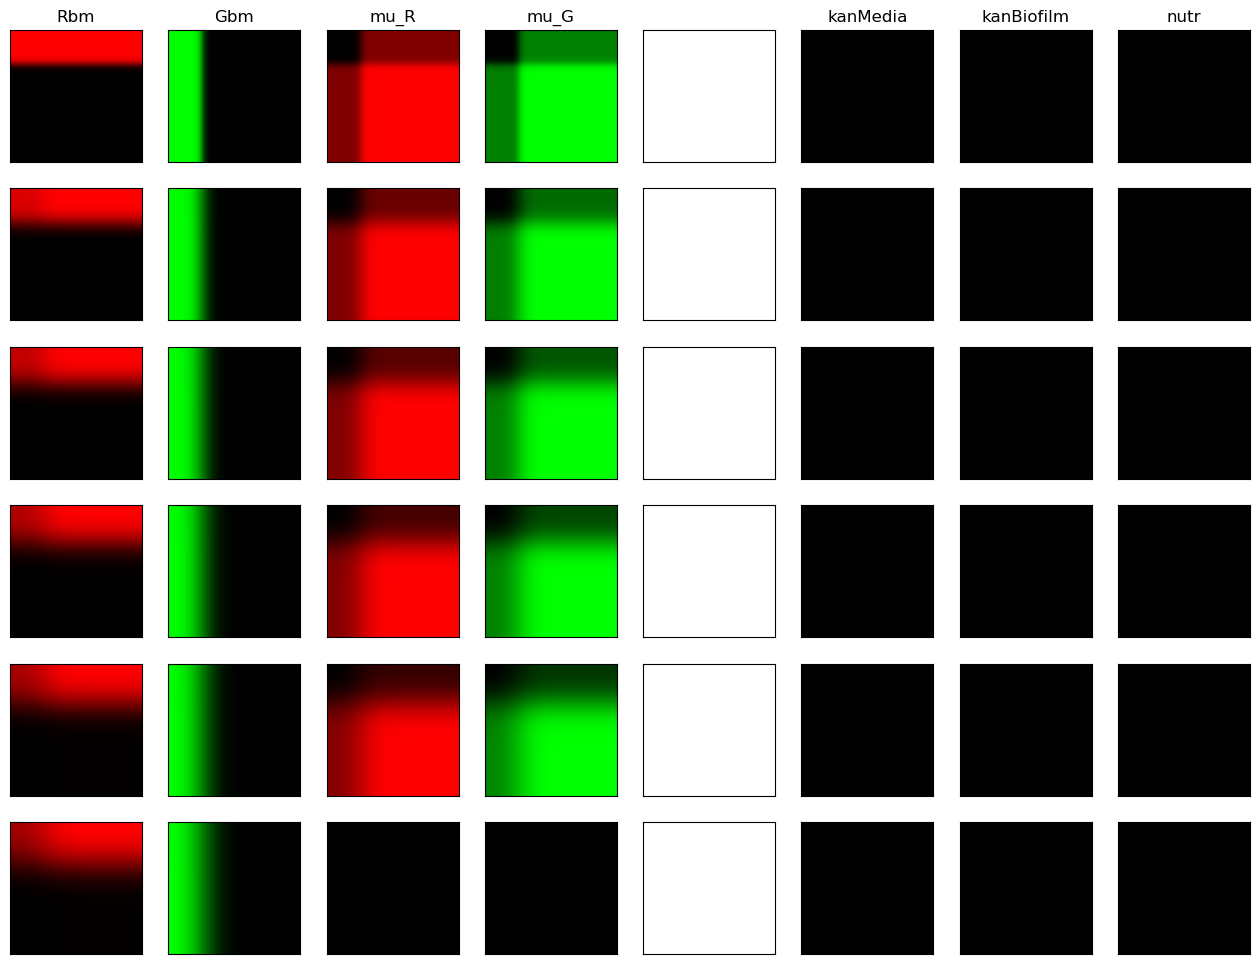

In [290]:
testSim=biofilmKanSimulate()
testSim.simulate()
testSim.showPlots()
simDf=testSim.getFits()
simDf

C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\Xiaofan\miniconda3\envs\biofilm\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information. 

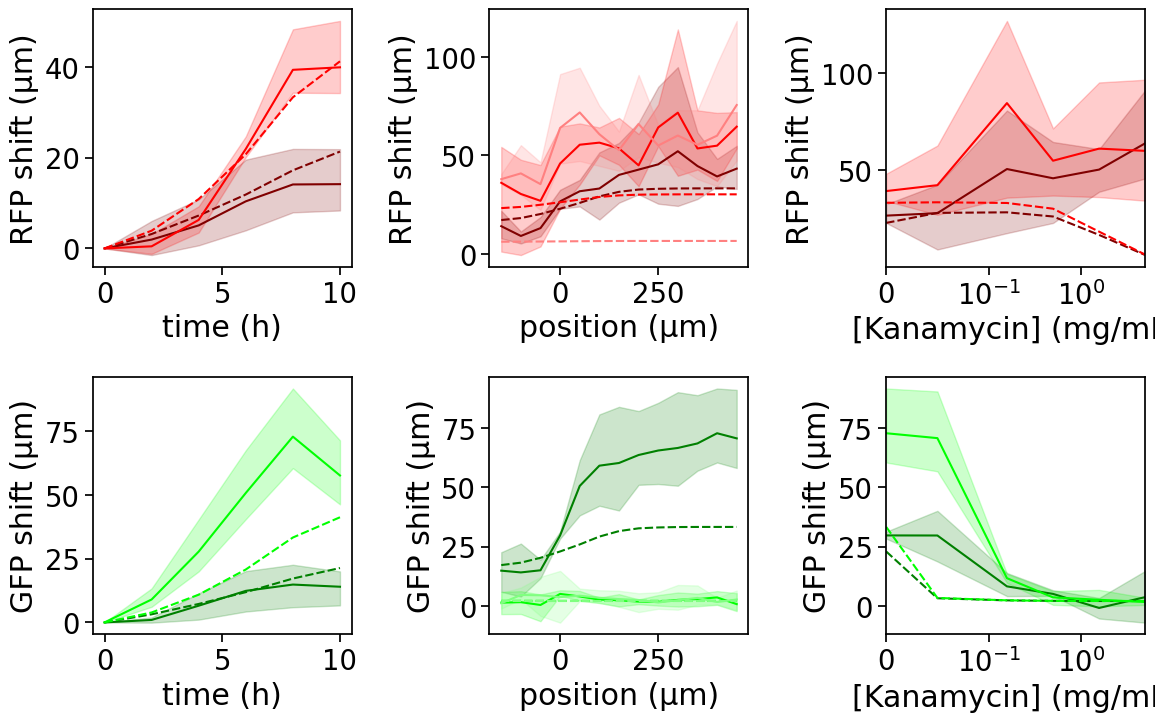

In [291]:
simKanGrad()